### Explanation
This code analyses time lapse images of plates with growing colonies and gets their size and mean fluorescence over time together with some valuable characterization of their dynamics. It uses the python module FluoPi to perform these tasks.

##### Requirements
 - All images have to be same size
 - Have _fluopi_ module installed (open Terminal in Mac or command line in Windows and type  `pip install fluopi`; more info [here](https://packaging.python.org/tutorials/installing-packages/) about installing python packages)


## Analysis

### Loading packages
As part of the [FluoPi](https://osf.io/dy6p2/) project we provide a python module to manage and analyse time lapse data. We will also use some common modules for plotting and analysing data:

In [2]:
# Import the FluoPi module
from fluopi import plotting as flup
from fluopi import analysis as flua
# import some useful packages to manage the data

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path

#modify some matplotlib parameters to manage the images for illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### General specifications

First, we have to define the experiment data folder

In [3]:
gpath = os.path.abspath('D:\GoogleDrive\Lab Dia a dia\opto timelapse\Colonia individual\Z capturtes')
print(gpath)

D:\GoogleDrive\Lab Dia a dia\opto timelapse\Colonia individual\Z capturtes


In [3]:
#Define the frames to be used. This value is common for fluorescence and whitelight data series.

Frames = 4   # Frames = 4 means use one image every 4 frames


Finally is important know the time step value used on the timelapse. It can be known from the python timelapse hardware control code stored on the folder (named 'interval' in the code).

In [4]:
#define it in hour units
dT=0.25  # hours, in this example interval = 1 hour for each frame

#dT= 1.0/12.0  # hours, uncomment if you use the original paper data where interval = 5 min for each frame


## White Light Data 

White light data shows the colonies growth

### Loading Data

In this section you have to include the path of the data to be used. Be careful because it asumes you have the images in a subfolder in the same path as this notebook. If you have the images in another external folder you have to include the full path direction (e.g. _'C/myuser/.../my_images_folder'_)

If you downloaded all the github repository you should have the images in the subfolder _'Images/'_ and then the path should be up and ready.

Also, the example data can be obtained from the **_Files_** section in the [OSF FluoPi proyect](https://osf.io/dy6p2/). There you can download it from the *Google drive/Example_data/Size_and_fluo* folder. Moreover, there you can found other image series of your interest.

After specifying the folder name where the images are stored, we are able to count the files:

In [5]:
w_data_folder = '/White/'
fpath = gpath+ w_data_folder
print(fpath)
imCount = flua.count_files(fpath, 'jpg')

# save the last image number name
lim=int(os.listdir(fpath)[-1].split('_')[-1].split('.')[0])

D:\GoogleDrive\Lab Dia a dia\opto timelapse\TL_3_09_19/White/
TL_3_09_19/White/ = 204 files


The _fluopi_ module provides a function to read images and save their values in 3-dimensional arrays (one for each channel). Now we can use this function to read and store the data of the images on a defined array for each channel:

In [6]:
prefix = 'OptoW1_'
im_fname = os.path.join(fpath, prefix + '%04d.jpg')

DataW={}
DataW['R'],DataW['G'],DataW['B'] = flua.get_im_data(Frames,imCount,im_fname)
DataW['Im']=im_fname     # to store the related image source

# also define a vector with the channels
channels=['R','G','B']

Finally, we can construct a **time vector** 'T' for *Data*  (Which will be common to all the analyzed data)

In [7]:
w,h,st=DataW['R'].shape
T=np.zeros((st))
for i in range(0,st):
    T[i]=(i)*Frames*dT

print(T)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]


### Data management

#### Background computation and substraction

To take the valuable data of images is good to know the amount of background we have on it, if it changes over time or how noisy is it.

By ploting a transect of pixel values for each channel on an image, we can figure the efect of background: 

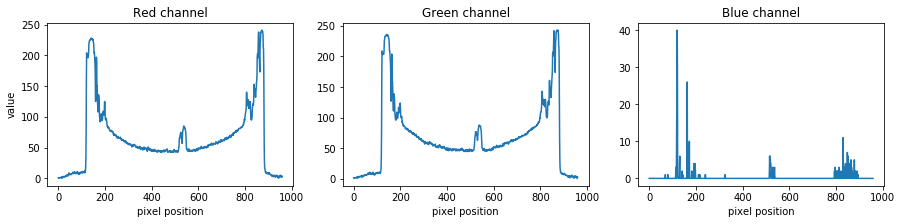

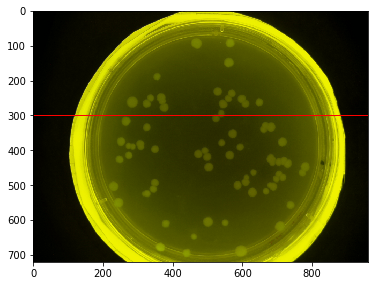

In [8]:
flup.row_transect(DataW, row=300)#int(w/2))

As you can see, data shows "peaks" (colonies) and a basal value along the line (background signal)

Then, to distinguish cell fluorescence from media and background light, we can select some empty sector on the image (i.e. without colonies) and compute his mean value on each frame.

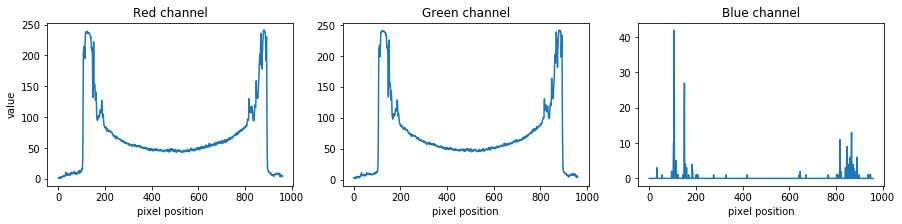

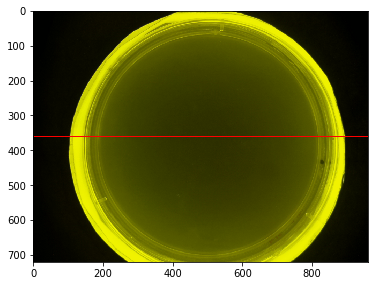

In [9]:
flup.row_transect(DataW, data_frame=8, row=int(w/2))

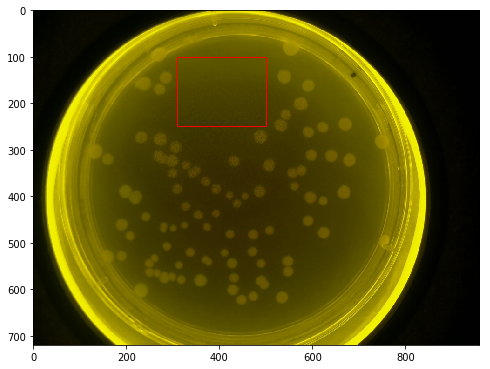

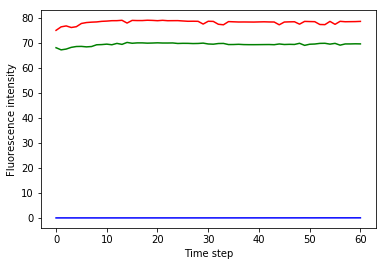

In [15]:
BG = flua.bg_value(100, 250, 310, 500, DataW, imCount)

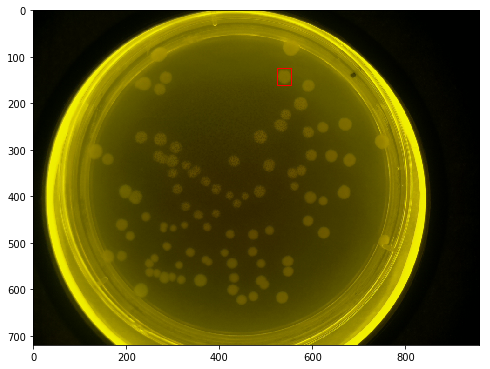

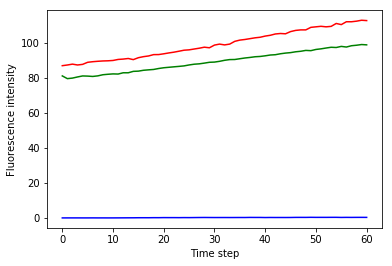

In [16]:
BG = flua.bg_value(125, 160, 525, 555, DataW, imCount)

It doesn´t seems to vary significantly over time.

Then, we could substract the mean value of the initial data points (i.e. first 8 hours) of each pixel to the whole serie.

In [11]:
CHANNELS = ['R','G','B']

In [10]:
def white_bg_value(data, images):
    """
    compute the background mean value for each channel and frame based on a rectagle
    defined by the user. Plot the rectangle over the image and makes plots of each channel
    mean background value over time

    Parameters
    ----------
   
    data : dictionary
        R G B images data to get the background, and his names on data['Im']
    
    im_count : array of integers
        array with the image numbers to be used. Number refers to the current selected images. i.e.
        image "2" is the second image in the selected images vector.

    Returns
    -------
    bg: dictionary
        Background mean value of each channel for every time frame

    """
    
    BG = {}
    plt.figure(figsize=(15,3))
    POS_VECT = [131,132,133]
    count = 0
    
    for chan in CHANNELS:
        
        BG[chan] = np.zeros((data[chan].shape[0],data[chan].shape[1]))
        
        for im in images:
            BG[chan] += data[chan][:,:,im]
        
        BG[chan] = BG[chan]/len(images)
        
        
        plt.subplot(POS_VECT[count])
        plt.imshow(BG[chan])
        plt.colorbar()
        plt.title(chan+' channel')
        count += 1

    return(BG)

Compute the background value

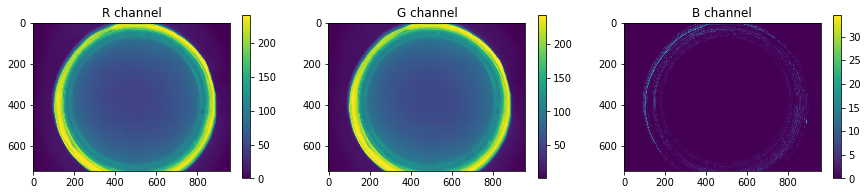

In [12]:
bg_images = [0,1,2,3,4,5,6,7]
wbg = white_bg_value(DataW, bg_images)

Subtract this value:

In [13]:
def white_bg_subst(data, wbg):
    
    """
    Substract the background value for each channel obtained with white_bg_value function.
    
    Parameters
    ----------
    data: dictionary
        R G B images data
        
    bg : dictionary
        dictionary with the average background value matrix for each channel 
        (can be obtained with white_bg_value function)


    Returns
    -------
    Data: dictionary
        R G B images data with the background substracted

    """
    
    m,n,l = data[CHANNELS[0]].shape  # the number of images      
    data_sb = {}
    
    for c in CHANNELS:
        data_sb[c] = np.zeros((m,n,l))
        
        for i in range(0,l):

            Data = data[c][:,:,i]-wbg[c]         #perform the substraction

            Data[Data<0] = 0        # values < 0 are not allowed --> transform it to 0

            data_sb[c][:,:,i] = Data   #actualize Data


    return(data_sb)

In [14]:
def frame_plot(data, frame):
    """
    Shows a desired image frame from the data
    
    Parameters
    ----------
    data: dictionary
        R G B images data
    frame : int
        number in dataS of the image frame to be shown


    Returns
    -------
    Data: dictionary
        R G B images data with the background substracted

    """
    plt.figure(figsize=(17,3))
    POS_VECT = [131,132,133]  
    count = 0
    
    for chan in CHANNELS:
                
        plt.subplot(POS_VECT[count])
        plt.imshow(data[chan][:,:,frame])
        plt.colorbar()
        plt.title(chan+' channel')
        count +=1

In [15]:
WDataSB = white_bg_subst(DataW, wbg)

We can check the effect of the subtraction

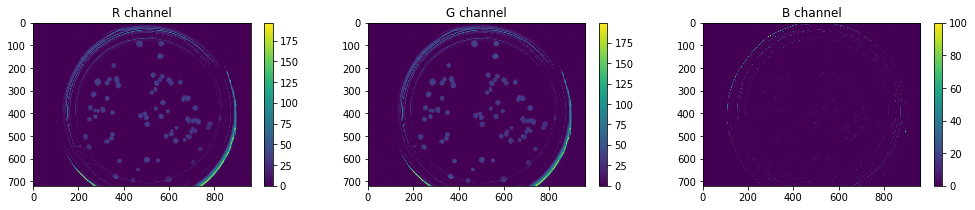

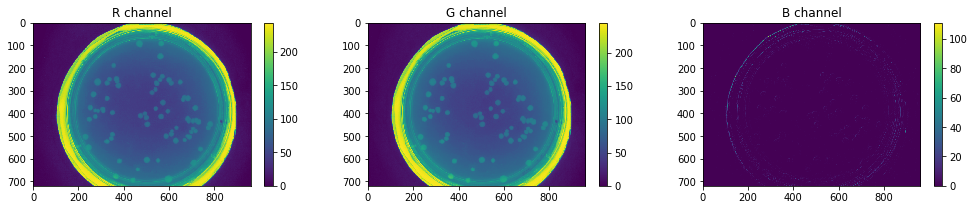

In [16]:
frame_plot(WDataSB,-1)
frame_plot(DataW,-1)

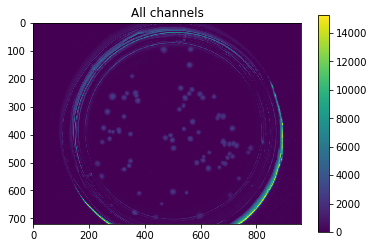

In [17]:
SumWData = flua.data_sum_time(WDataSB)

In [18]:
from skimage.filters import gaussian

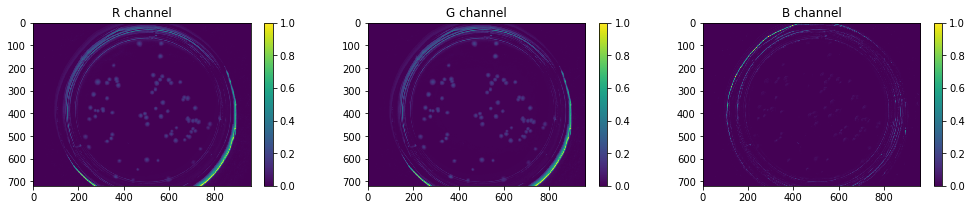

In [19]:
smooth_sigma = 0.7
sDatW,sDatWall,sDatWT=flua.smooth_data(WDataSB,sigma= smooth_sigma)

Previous
After Smooth
Sumarized Result


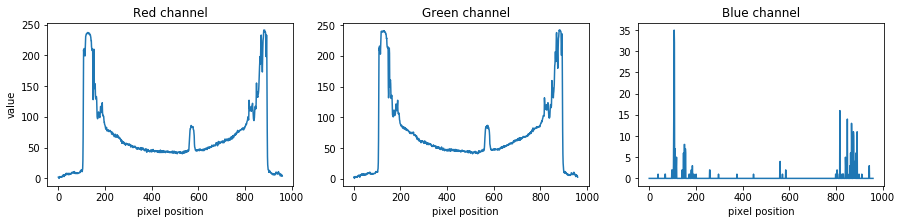

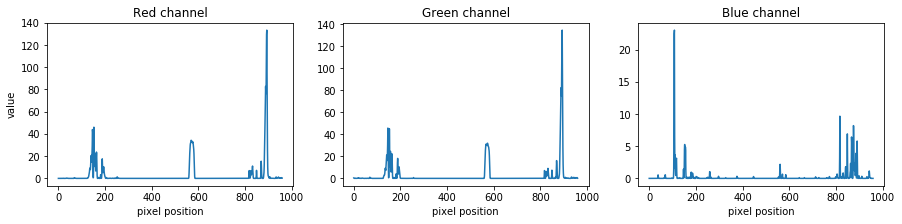

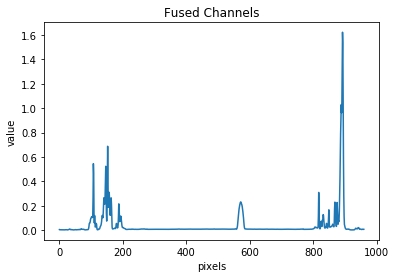

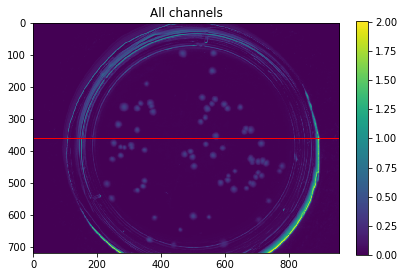

In [20]:
row = int(w/2)    ## int(w/2) is the middle row

print('Previous')
flup.row_transect(DataW,row,show_im=False)

print('After Smooth')
flup.row_transect(sDatWT,row,show_im=False)

print('Sumarized Result')
flup.row_transect(sDatWall,row,show_im=True)

In [21]:
def plot_im_circle(image, center, radius):
    
       
    plt.imshow(image)
    plt.colorbar()
        
    if radius != 'null':

        circle = plt.Circle((center[0], center[1]), radius, color='r', fill=False , lw=2)
        fig = plt.gcf()
        ax = fig.gca()
        ax.add_artist(circle)

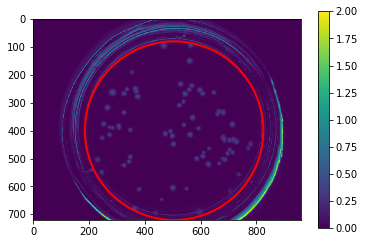

In [75]:
center = [505,400]
rad = 320
plot_im_circle(sDatWall,center, rad)

In [76]:
def just_circle(image, center, r):
    
    N,M= image.shape
    
    im_circle = np.zeros((N,M))
    y = center[0]
    x = center[1]
    
    for n in range(N):
        for m in range(M):
            if ((n-x)**2+(m-y)**2) <= (r**2):
                im_circle[n,m] = image[n,m]
    
    plt.figure(figsize=(12,3))
    
    plt.subplot(121)
    plt.imshow(image)
    plt.colorbar()
    plt.title("Original Image")
    
    plt.subplot(122)
    plt.imshow(im_circle)
    plt.colorbar()
    plt.title("circle crop image")
    
    return(im_circle)

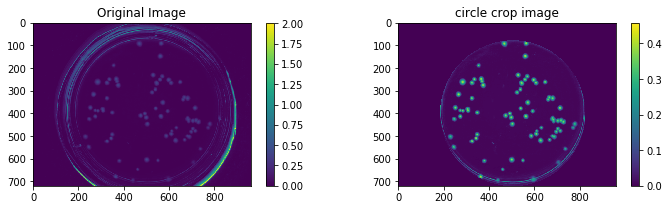

In [77]:
circle_sDatWall = just_circle(sDatWall,center, rad)

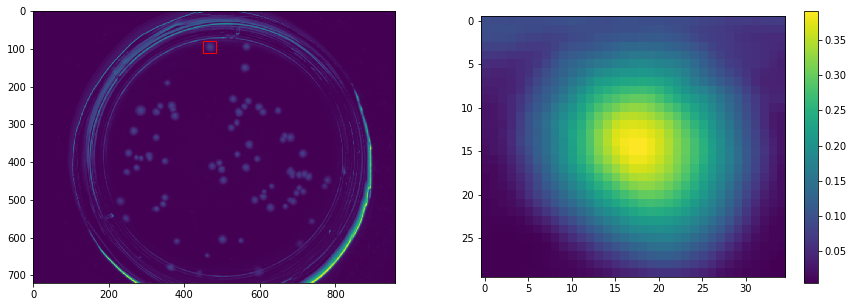

In [78]:
# perform a Zoom by slicing the image:

# modify next values accord the section you want to see:

y_lims = [80,110]    
x_lims = [450,485]    

########################
# Just make the plot ###
########################
flup.im_zoom(y_lims, x_lims, sDatWall)

In [106]:
# assign the stimated radius value

Rmin = 10
Rmax = 11

#perform the sigma limits computation:

Slims = [Rmin/(2**0.5),Rmax/(2**0.5)]
print('sigma limits are: ' + str(Slims))

sigma limits are: [7.071067811865475, 7.7781745930520225]


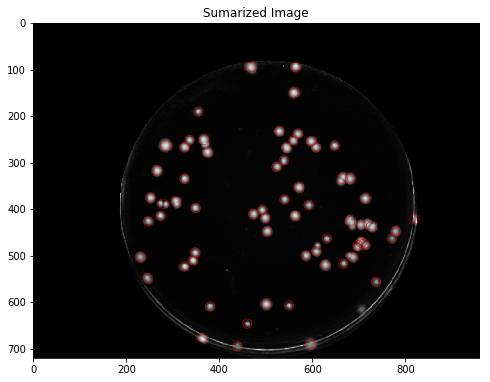

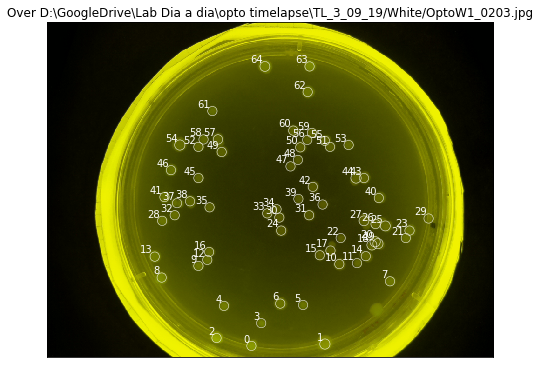

In [107]:
threshold = 0.08
overlap = 0.8
blobD = flua.colony_blobs_id(circle_sDatWall,im_fname%(lim),threshold,sigma_lims = Slims, max_over = overlap)#,filename='Plots/Size_and_fluo/DetectedBlobs')

In [108]:
print('min radius is ' + str(blobD[:,2].min()*(2**0.5))+'\n')
print('max radius is ' + str(blobD[:,2].max()*(2**0.5))+'\n')

min radius is 10.0

max radius is 11.0



In [109]:
#### to save the details at the end
detection_info = {
    "image_name" : im_fname%(lim),
    "sum_image" : circle_sDatWall,
    "R": [Rmin, Rmax],
    "threshold": threshold,
    "max_overlap": overlap,
    "smooth_sigma": smooth_sigma,
    "background_images" : bg_images
}

In [111]:
col_del = [20,25,27,29,34,37,38,57]
nblobD = np.delete(blobD, col_del, axis=0)

In [112]:
def plot_id_colonies(data, im_name, blobs, filename='null'):
    
    A = blobs
    
    plt.figure(figsize=(8,8))
    plt.imshow(data, cmap='gray')
    #plt.hold(True)
    plt.title('Sumarized Image')
    for i in range(len(A)):
        circle = plt.Circle((A[i,1], A[i,0]), (2**0.5)*A[i,2], color='r', fill=False , 
                            lw=0.5)
        fig = plt.gcf()
        ax = fig.gca()
        ax.add_artist(circle)

    plt.figure(figsize=(8,8))
    plt.imshow(plt.imread(im_name))
    #plt.hold(True)
    plt.title('Over '+ im_name)
    for i in range(len(A)):
        # plot the circle area identified for each colony
        circle = plt.Circle((A[i,1], A[i,0]), (2**0.5)*A[i,2], color='w', fill=False , lw=0.5)
        fig = plt.gcf()
        ax = fig.gca()
        ax.add_artist(circle)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
        # attach the ID label to each colony
        plt.annotate(i, xy=(A[i,1], A[i,0]), xytext=(-2, 2),
                     textcoords='offset points', ha='right', va='bottom',
                     color='white')
    if filename != 'null':
        plt.savefig(str(filename) + ".pdf", transparent=True)    
    

In [113]:
#os.mkdir('Plots/')
os.mkdir('Plots/'+gpath.split('\\')[-1])
G_path = 'Plots/'+gpath.split('\\')[-1]+'//Growth'
os.mkdir(G_path)

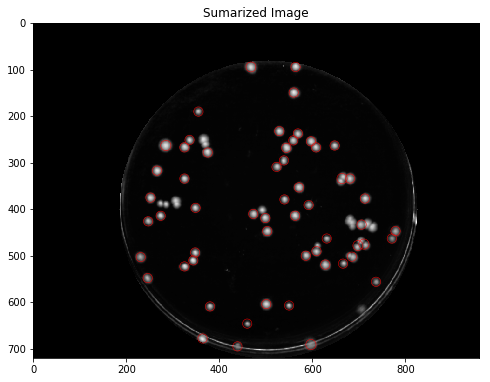

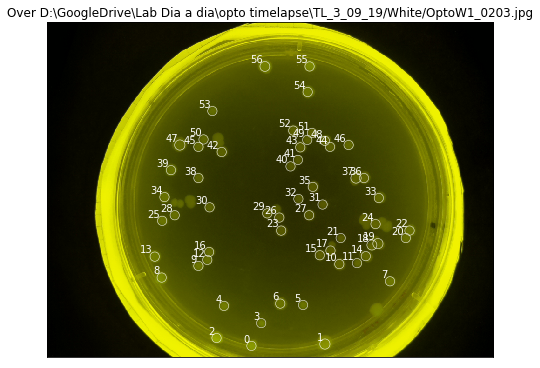

In [114]:
plot_id_colonies(circle_sDatWall,im_fname%(lim), nblobD, filename=G_path+'//DetectedBlobs')

In [115]:
colonies = list(range(0,nblobD.shape[0],3))

In [148]:
colonies = [3, 4, 6, 9, 15, 21, 24, 25, 27, 30, 32, 34, 38, 39, 45, 46, 51, 52, 53, 54]

In [149]:
Rois,RoisC,NC = flua.obtain_rois(sDatWT,nblobD)

ROI x1 x2 y1 y2
0 681 710 425 454
ROI x1 x2 y1 y2
1 675 708 581 614
ROI x1 x2 y1 y2
2 664 693 350 379
ROI x1 x2 y1 y2
3 632 661 446 475
ROI x1 x2 y1 y2
4 595 624 366 395
ROI x1 x2 y1 y2
5 593 622 536 565
ROI x1 x2 y1 y2
6 590 619 487 516
ROI x1 x2 y1 y2
7 542 571 723 752
ROI x1 x2 y1 y2
8 534 563 232 261
ROI x1 x2 y1 y2
9 509 538 311 340
ROI x1 x2 y1 y2
10 505 534 614 643
ROI x1 x2 y1 y2
11 503 532 652 681
ROI x1 x2 y1 y2
12 496 525 330 359
ROI x1 x2 y1 y2
13 489 518 217 246
ROI x1 x2 y1 y2
14 488 517 671 700
ROI x1 x2 y1 y2
15 486 515 572 601
ROI x1 x2 y1 y2
16 479 508 334 363
ROI x1 x2 y1 y2
17 476 505 595 624
ROI x1 x2 y1 y2
18 463 494 683 714
ROI x1 x2 y1 y2
19 459 492 695 728
ROI x1 x2 y1 y2
20 449 478 757 786
ROI x1 x2 y1 y2
21 449 478 617 646
ROI x1 x2 y1 y2
22 433 462 765 794
ROI x1 x2 y1 y2
23 433 462 489 518
ROI x1 x2 y1 y2
24 419 448 692 721
ROI x1 x2 y1 y2
25 412 441 233 262
ROI x1 x2 y1 y2
26 405 434 485 514
ROI x1 x2 y1 y2
27 400 429 549 578
ROI x1 x2 y1 y2
28 400 429 260

Create the folder to store ROIs images:

In [120]:
#os.mkdir('ROIs/')
os.mkdir('ROIs/'+gpath.split('\\')[-1])

w_rois_path = 'ROIs/'+gpath.split('\\')[-1]+w_data_folder
os.mkdir(w_rois_path)

Colony 6


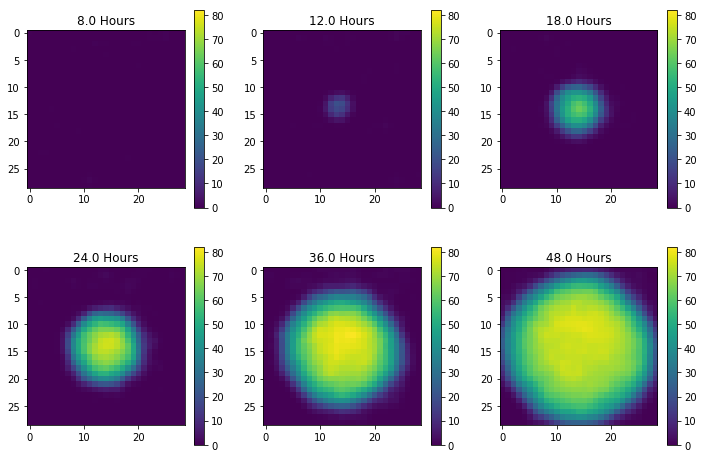

In [154]:
IDCol=colonies[2]
fname=(w_rois_path+'Col'+str(IDCol)+'_ROI_step%d.png')
Rois_frames=[8,12,18,24,36,48]       # this are positions on the time vector, not directly "times" (e.g. 24 = T[24] and not 24 h)

flup.tl_roi(Rois,T,IDCol,Rois_frames,fname,chan_sum=True,gridsize=[2,3])
print('Colony '+str(IDCol))

Each line correspond to a different ROI


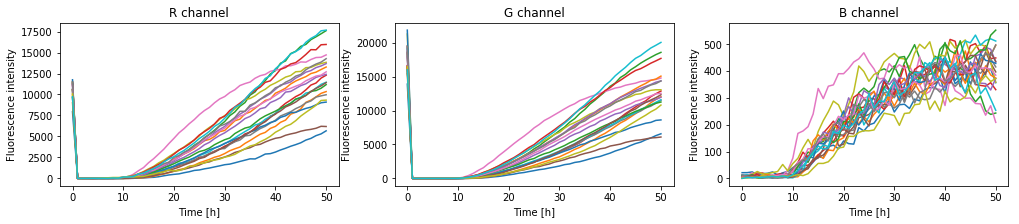

In [155]:
#define the selected colonies
#Cols=list(range(0, len(colonies)),2)  # takes one every two of previouly selected colonies

#use the function to plot
flup.rois_plt_fluo_dynam(RoisC,T,colonies)
#flup.rois_plt_fluo_dynam(RoisC,T,Cols,filename='Plots/Size_and_fluo/Channel_total_intensity')

print('Each line correspond to a different ROI')

In [156]:
ACRoisS=flua.channels_sum(Rois,colonies) #square ROIS

In [157]:
# This block could be a bit slow, don't get stressed.

tl_threshold = 0.25

import time
start = time.time()
R_frame = flua.frame_colony_radius(ACRoisS, colonies, tl_threshold, max_sig = Slims[1]*1.1)
end = time.time()
print(str(end - start)+' seg') #to know how long it takes to run

553.62926030159 seg


Each line correspond to one colony


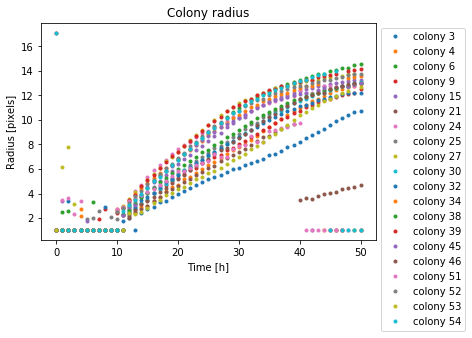

In [158]:
#flup.plot_radius(R_frame, Cols, T)
flup.plot_radius(R_frame, colonies, T)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
print('Each line correspond to one colony')

D:\Github\FluoPi\FluOpti\fluopi\plotting.py:521: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_dots != 'null':


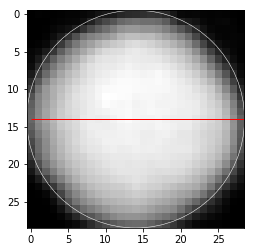

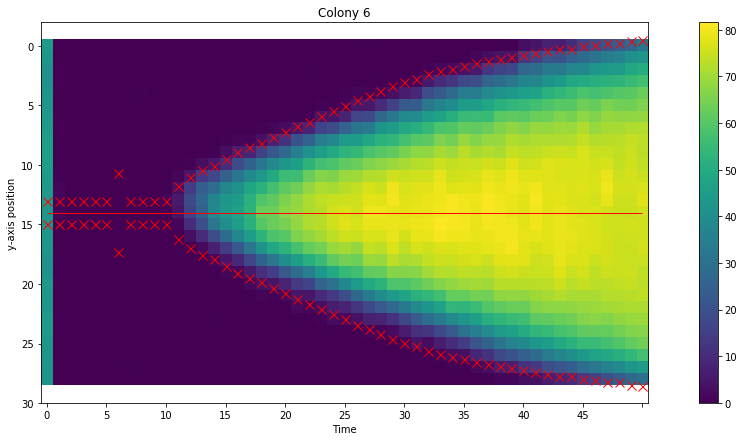

In [161]:
IDCol=colonies[2]

# See one frame of the colony
flup.ROI_radius(ACRoisS, IDCol, frame= -1, r= R_frame, transect = True , plt_circle = True)

# See the time serie transect radius
#flup.check_radius(ACRoisS, IDCol, T, r_dots=R_frame[IDCol], transect=True)
flup.check_radius(ACRoisS, IDCol, T, r_dots=R_frame[IDCol], transect=True,filename='Plots/5_9_19_TL/Growth/Kymograph_'+str(IDCol))


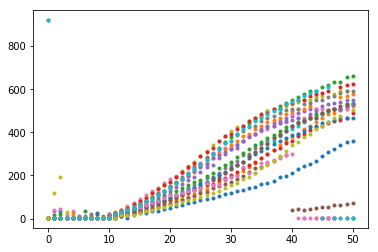

In [162]:
A = flua.area(R_frame,colonies,T)

In [177]:
5,11,14,16,18,19

(5, 11, 14, 16, 18, 19)

In [178]:
colonies[19]

54

In [179]:
colonies = list(np.delete(colonies, [5,11,14,16,18,19]))

In [180]:
colonies

[3, 4, 6, 9, 15, 24, 25, 27, 30, 32, 38, 39, 46, 52]

In [164]:
def f_gompertz(t, a, b, c):
    """
    Compute the gompertz function value using the given input values
    
    Parameters
    ----------
        t: vector
            independent variable ( "x axis", suposed to be time) 
        
        a: double
            maximum growth value parameter
        
        b: double
            maximum growth rate parameter
            
        c: double
            delay parameter
        
    Returns
    -------
    function evaluation
    
    """
    return(a*np.exp(-np.exp(1 + b*np.exp(1)*(c-t)/a)))  

[1692.61379594   17.68710287   29.87567997]


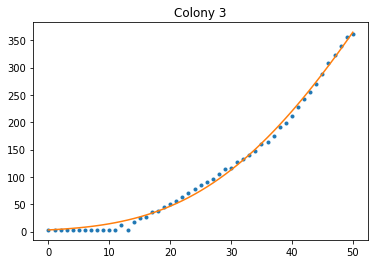

[922.06603618  17.99932248  19.32703602]


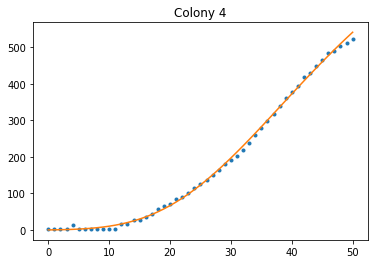

[732.58498882  23.63920075  14.1080698 ]


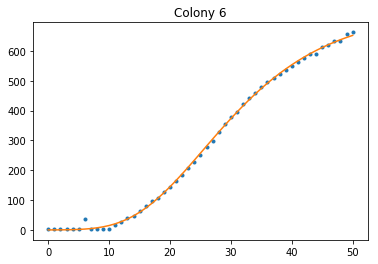

[746.71242685  15.1293071   16.19864397]


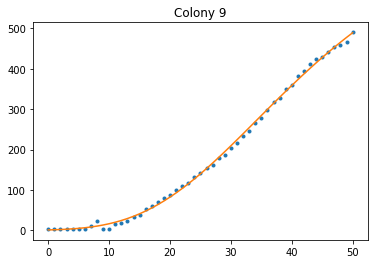

[624.4412146   20.42076216  14.14611545]


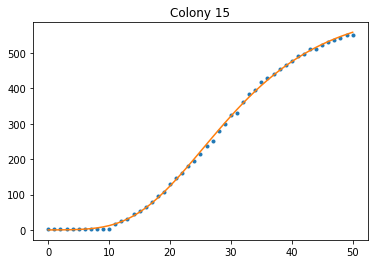

[566.52296081  18.27562133  10.69716851]


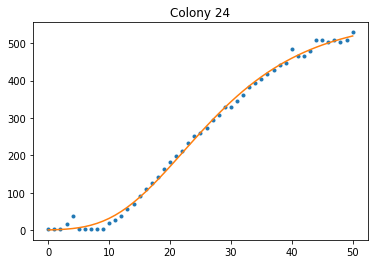

[718.97806096  17.18093299  15.10632725]


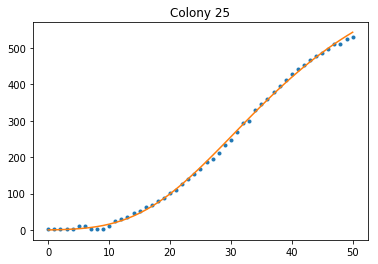

[541.10483883  25.61717317  12.8724518 ]


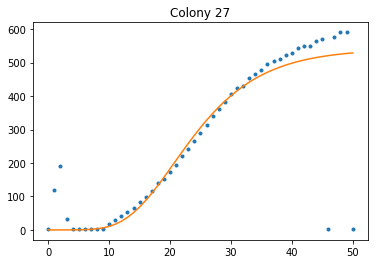

[750.82622516  17.48509343  16.2382378 ]


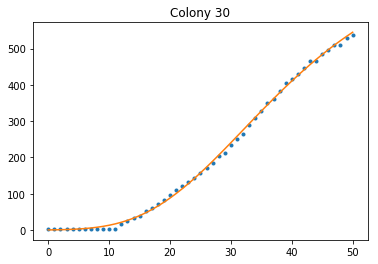

[622.21575001  15.51224817  14.73019379]


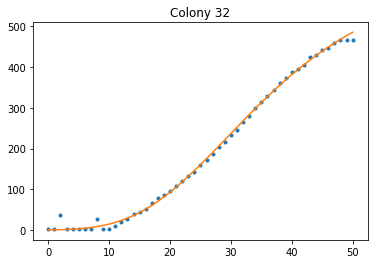

[667.59195671  17.37266553  14.36092636]


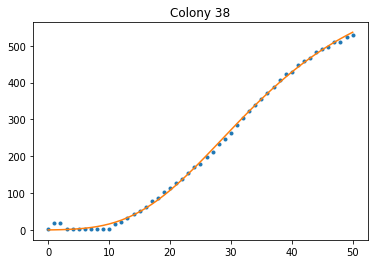

[553.95961546  25.52918005  12.99635855]


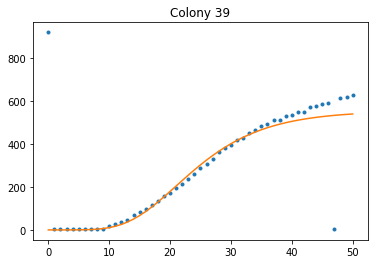

[748.78489797  18.27508417  17.05151153]


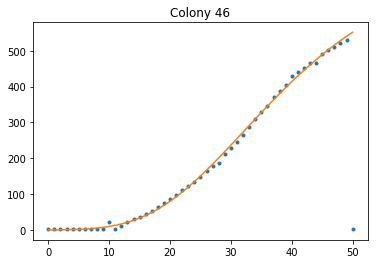

[644.63704734  21.68358903  12.98651056]


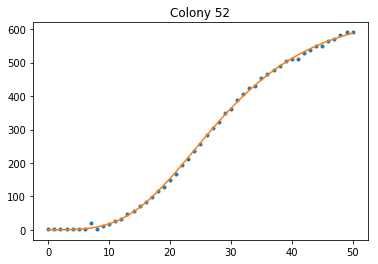

In [181]:
init=0
end=-1
fit_func = f_gompertz
p_bounds = ([10,0,0],[np.inf,np.inf,np.inf])

A_fitG=flua.function_fit(T,A,init,end,colonies,func=fit_func, param_bounds= p_bounds)

In [182]:
#### to save the details at the end
fitting_info = {
    "function" : fit_func,
    "param boundaries" : p_bounds,
    "limits" : [init, end],
    "radius timeserie threshold" : tl_threshold
}

In [183]:
#set the color vector to have concordance between dots and fitted curves
colors = plt.cm.jet(np.linspace(0, 1, len(colonies))) #Paired o jet #https://matplotlib.org/users/colormaps.html


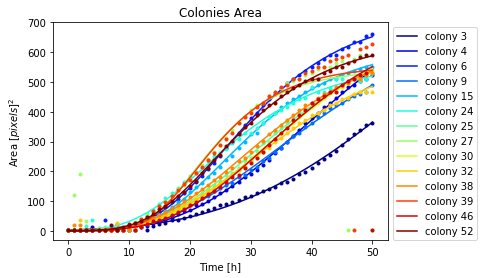

In [187]:
for i, c in zip(colonies, colors):
    plt.plot(T,A[i],'.',color=c)
    plt.plot(T,A_fitG[i][0],'-',color=c,label='colony '+str(i))

plt.xlabel('Time [h]')
plt.ylabel('Area $[pixels]^2$') 
plt.title('Colonies Area')
plt.ylim([-30,700])

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(G_path+"//AreaFit.pdf", transparent=True)  # Uncomment this line to save

#plt.legend(loc='upper left')
#plt.savefig(G_path+"//AreaFit_colonies_label.pdf", transparent=True)  # Uncomment this line to save

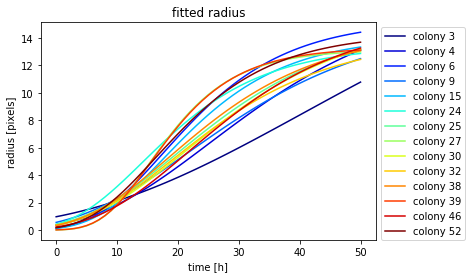

In [188]:
from math import pi
r_fit={}

plt.figure()
for i, c in zip(colonies, colors):
    r_fit[i]=(A_fitG[i][0]/pi)**(0.5)
    
    plt.plot(T,r_fit[i],'-',color=c,label='colony '+str(i))

plt.title('fitted radius')
plt.ylabel('radius [pixels]')
plt.xlabel('time [h]')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.savefig(G_path+"//colonyRadiusFit.pdf", transparent=True)

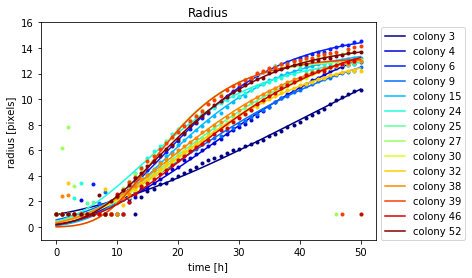

In [191]:
#fluopi.plot_radius(R_frame5,Cols,T)
for i, c in zip(colonies, colors):
    plt.plot(T,R_frame[i],'.',color=c)
    plt.plot(T,r_fit[i],'-',color=c,label='colony '+str(i))
plt.title('Radius')
plt.ylabel('radius [pixels]')
plt.xlabel('time [h]')
plt.ylim([-1,16])

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(G_path+"//colonyRadiusFit_points.pdf", transparent=True)

D:\Github\FluoPi\FluOpti\fluopi\plotting.py:516: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_fit != 'null':
D:\Github\FluoPi\FluOpti\fluopi\plotting.py:521: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_dots != 'null':


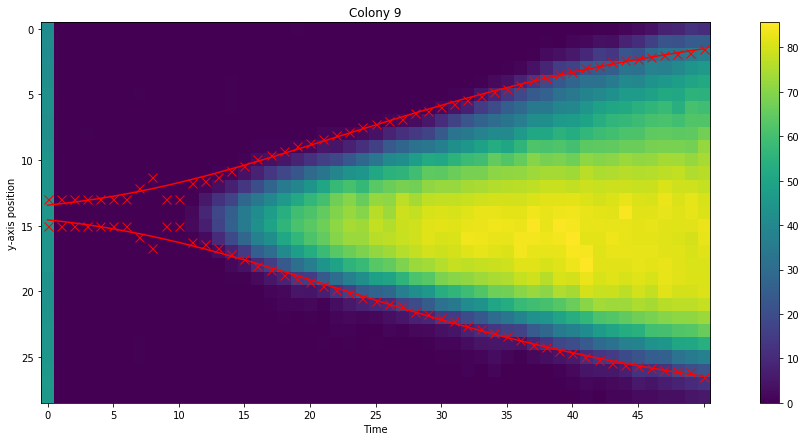

In [195]:
IDCol=int(colonies[3])

#flup.check_radius(ACRoisS,IDCol,T,r_fit=r_fit[IDCol],r_dots=R_frame[IDCol])
flup.check_radius(ACRoisS,IDCol,T,r_fit=r_fit[IDCol],r_dots=R_frame[IDCol], filename='Plots/5_9_19_TL/Growth/3Kymograph_fit2_color_'+str(IDCol))

D:\Github\FluoPi\FluOpti\fluopi\plotting.py:305: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if radius != 'null':
D:\Github\FluoPi\FluOpti\fluopi\plotting.py:343: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if radius != 'null':


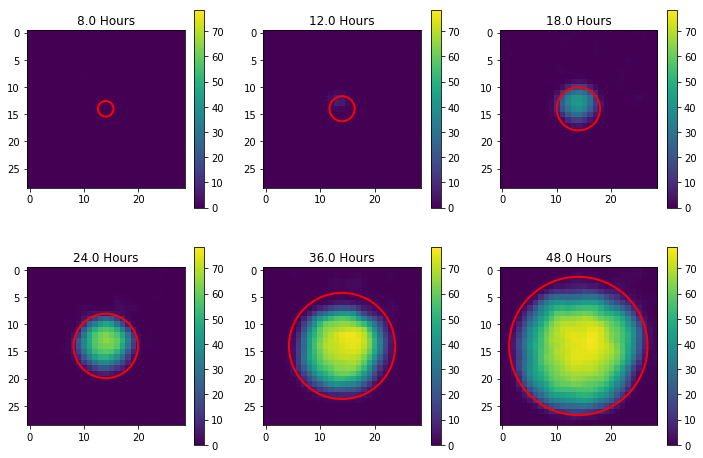

In [198]:
IDCol=int(colonies[1])
fname=(w_rois_path+'sumCol'+str(IDCol)+'_ROI_step%d.png')
#fname=(w_rois_path+'sumCol'+str(IDCol)+'_ROI_step%d.pdf')
frames=[8,12,18,24,36,48]    

flup.tl_roi(Rois,T,IDCol,frames,fname,radius=r_fit[IDCol], chan_sum=True, same_bar= True, gridsize=[2,3]) 

In [200]:
def f_gmu (t,a,b,c):
    """
    compute the gompertz growth rate (mu) function value
    
    Parameters
    ----------
        t: int or vector
             independent variable values (suposed to be time vector)
        
        b: double
            functon parameter
        
        c: double
           function parameter
        
        
    Returns
    -------
        evaluated "mu" fucntion with the given parameters

    
    """
    return(b*np.exp(2 + (b* np.exp(1)*(c - t))/a)/a)


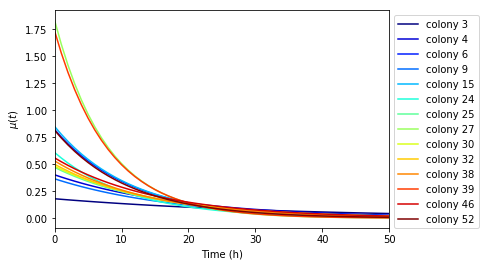

In [201]:
Mu_val={}
for i, c in zip(colonies, colors):
    Mu_val[i]=f_gmu(T,A_fitG[i][1][0],A_fitG[i][1][1],A_fitG[i][1][2])
    plt.plot(T,Mu_val[i],'-',color=c,label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel(r'$\mu (t)$')
    plt.xlim([0,50])
    #plt.ylim([0,0.30])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.savefig("Plots/Size_and_fluo/GrowthRate.pdf", transparent=True) # Uncomment to save

In [433]:
def f_logistic(t, a, b, c):
    """
    Compute the sigmoide function value using the given input values
    
    Parameters
    ----------
        t: vector
            independent variable ( "x axis", suposed to be time) 
        
        a: double
            maximum value parameter
        
        b: double
            maximum growth rate parameter
            
        c: double
            delay parameter
        
    Returns
    -------
    function evaluation
    
    """
    return(a/(1 + np.exp( 2 + 4*b*(c-t)/a)))  

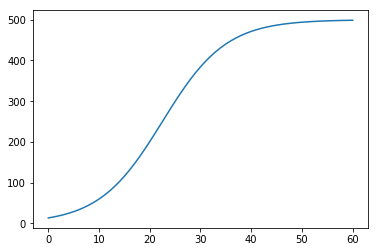

In [445]:
F_logis = f_logistic(T, 500, 20, 10)
plt.plot(T,F_logis)

[380.34976015  15.00126275  13.13614275]


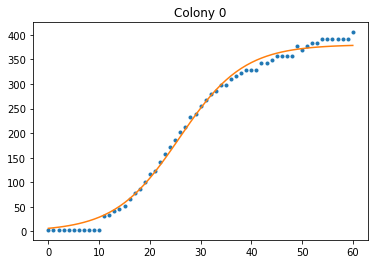

[758.16104515  34.10610695  10.49105317]


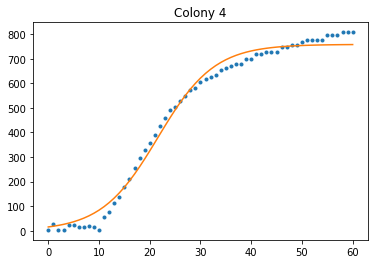

[415.36101604  20.85217585  10.28997055]


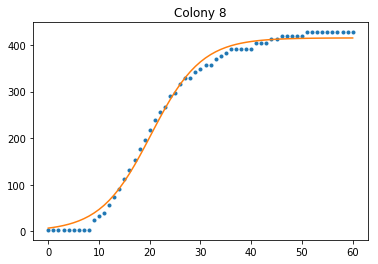

[209.28814237  20.72873337  10.10963266]


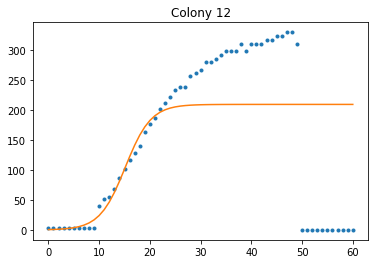

[544.97186662  29.67094126   8.56224223]


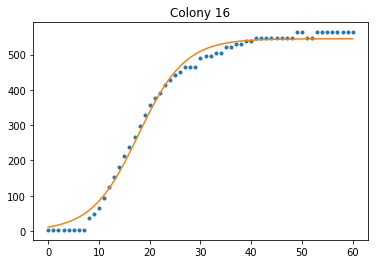

[280.41883505  11.77324981   9.79073059]


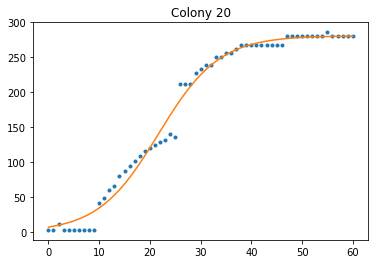

[462.15226462  22.42809047  10.77517961]


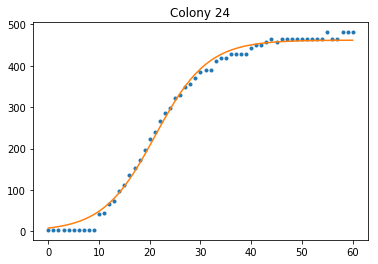

[394.243201    20.73447725  11.62723456]


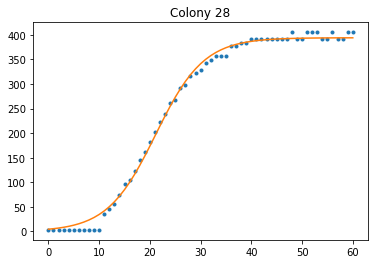

[388.15915038  20.18035344  10.12630298]


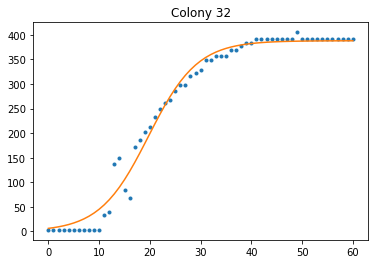

[507.4402646   19.89492201  12.98554   ]


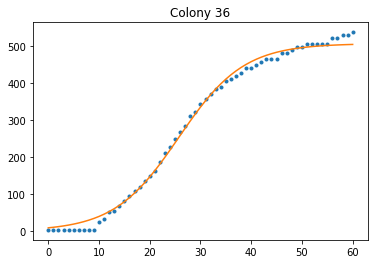

[389.6268952   25.90430848  10.48472598]


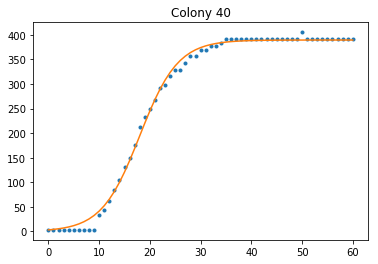

[655.73986852  27.45459869  11.4270751 ]


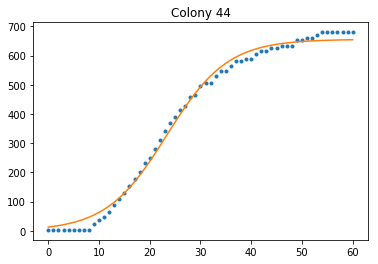

[708.57849158  29.6622454    8.18801749]


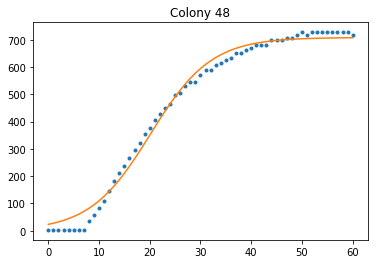

[342.20124459  13.70949294  12.89698368]


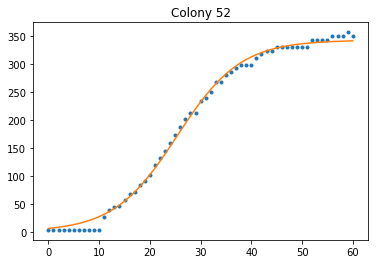

[466.68369019  45.28975739  13.11172796]


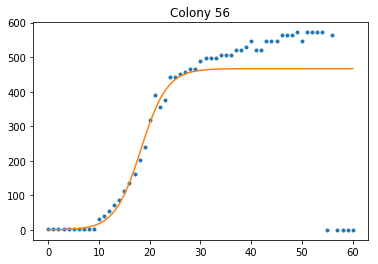

[501.7548307   21.76879092  11.97592621]


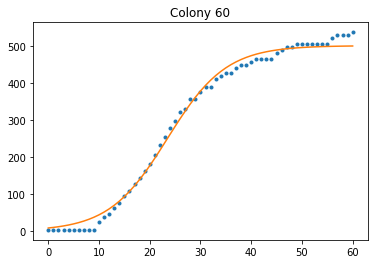

[416.00827484  49.86867723  13.87837215]


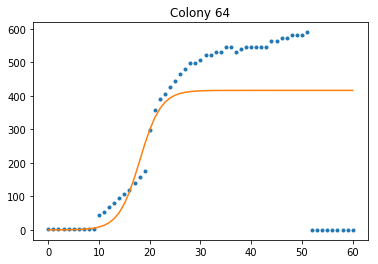

[370.33491729  34.75714044  11.4815148 ]


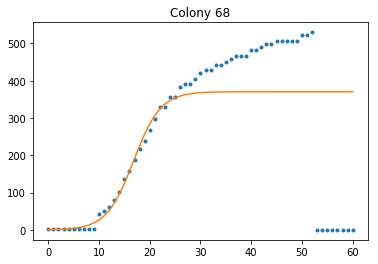

[753.22128112  33.12803428  12.17943466]


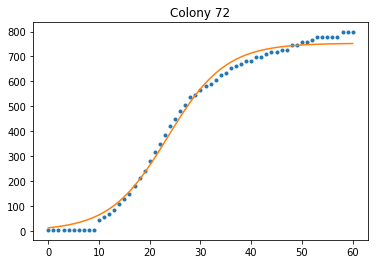

[788.77147076  29.77916914  14.08196845]


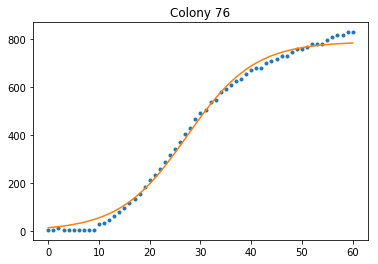

[644.45025572  21.95753248  14.46447322]


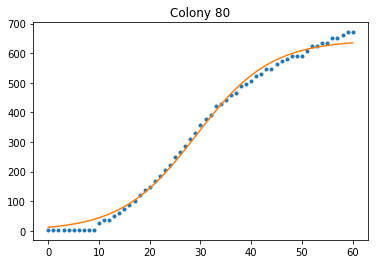

In [446]:
init=0
end=-1
A_fitL=flua.function_fit(T,A,init,end,colonies,func=f_logistic, param_bounds=([10,0,0],[np.inf,np.inf,np.inf]))

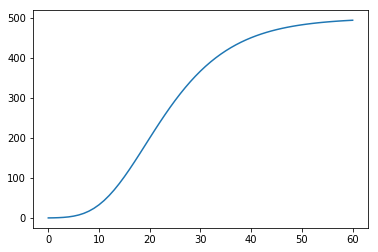

In [455]:
F_gomp = f_gompertz(T, 500, 20, 10)
plt.plot(T,F_gomp)

In [202]:
DataW = {}

### Fluorescent data

In [9]:
f_data_folder = '/RG High C/Raw2/'
fpath = gpath+ f_data_folder
print(fpath)
imCount = flua.count_files(fpath, 'jpg')

# save the last image number name
lim=int(os.listdir(fpath)[-1].split('_')[-1].split('.')[0])

D:\GoogleDrive\Lab Dia a dia\opto timelapse\Colonia individual\Z capturtes/RG High C/Raw2/
Z capturtes/RG High C/Raw2/ = 1 files


In [8]:
#data_folder = '/White/'
#fpath = gpath+ data_folder
fpath = os.path.abspath('D:\GoogleDrive\Lab Dia a dia\opto timelapse\TL_3_09_19\Raw3')
print(fpath)
imCount = flua.count_files(fpath, 'jpg')

# save the last image number name
lim=int(os.listdir(fpath)[-1].split('_')[-1].split('.')[0])

D:\GoogleDrive\Lab Dia a dia\opto timelapse\TL_3_09_19\Raw3
Raw3 = 204 files


In [11]:
Frames = 1

In [12]:
prefix = 'OptoN2_'
im_fname = os.path.join(fpath, prefix + '%04d.jpg')

DataF={}
DataF['R'],DataF['G'],DataF['B'] = flua.get_im_data(Frames,imCount,im_fname)
DataF['Im']=im_fname     # to store the related image source

# also define a vector with the channels
channels=['R','G','B']

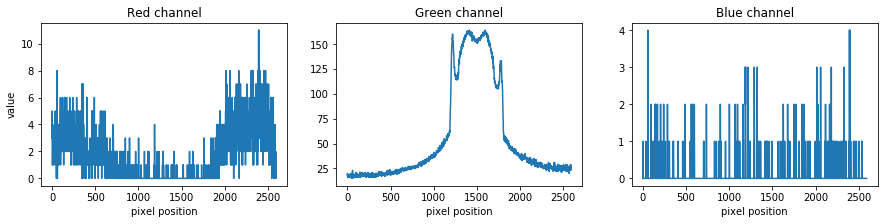

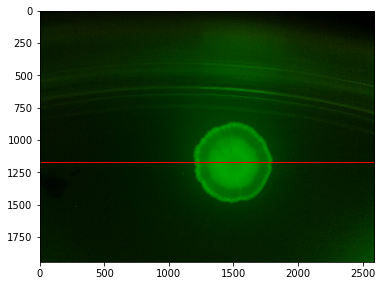

In [18]:
flup.row_transect(DataF, row=1170)

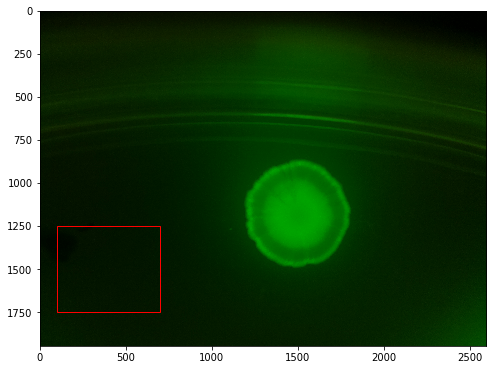

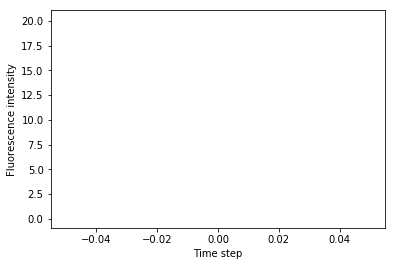

In [20]:
BG = flua.bg_value(1250, 1750, 100, 700, DataF, imCount)

In [21]:
DataFsB = flua.bg_subst(DataF,BG)

In [29]:
DataFsB['R'].shape 

(1944, 2592, 1)

In [30]:
n_lim = [750,1750]
m_lim = [1000,2000]
Data_crop = {}
for c in channels:
    Data_crop[c] = DataFsB[c][n_lim[0]:n_lim[1], m_lim[0]:m_lim[1],:]

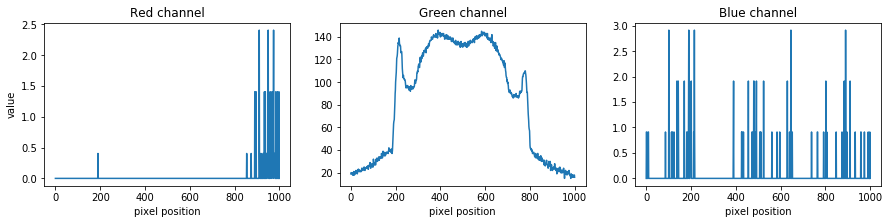

In [37]:
flup.row_transect(Data_crop, row=430)#, show_im = False)
plt.savefig('Plots'+"//Transect_C_1170.pdf", transparent=True) 

In [26]:
frame_plot(DataFsB,-1)
frame_plot(DataF,-1)

NameError: name 'frame_plot' is not defined

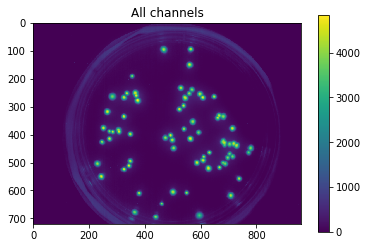

In [217]:
SumData = flua.data_sum_time(DataFsB)

In [218]:
F_path = 'Plots/'+gpath.split('\\')[-1]+'//Fluo'
os.mkdir(F_path)

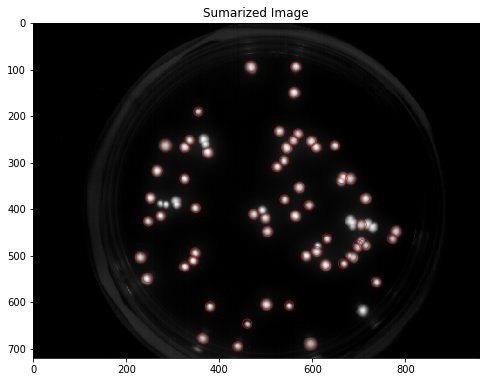

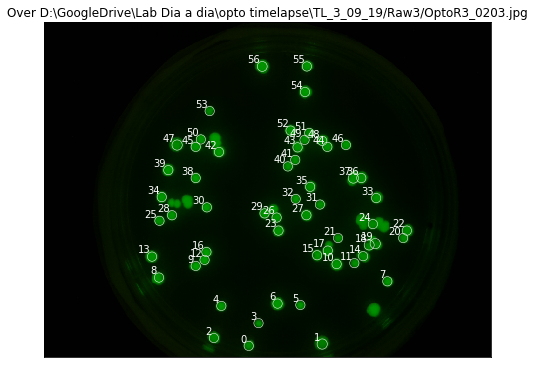

In [219]:
plot_id_colonies(SumData,im_fname%(lim), nblobD, filename=F_path+'//DetectedBlobs')

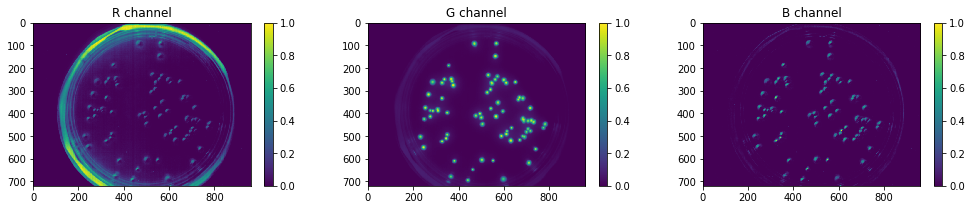

In [220]:
f_smooth_sigma = 0.7
sDatS,sDatSall,sDatST=flua.smooth_data(DataFsB,sigma = f_smooth_sigma)

In [221]:
FRois,FRoisC,NC = flua.obtain_rois(DataFsB,nblobD)

ROI x1 x2 y1 y2
0 681 710 425 454
ROI x1 x2 y1 y2
1 675 708 581 614
ROI x1 x2 y1 y2
2 664 693 350 379
ROI x1 x2 y1 y2
3 632 661 446 475
ROI x1 x2 y1 y2
4 595 624 366 395
ROI x1 x2 y1 y2
5 593 622 536 565
ROI x1 x2 y1 y2
6 590 619 487 516
ROI x1 x2 y1 y2
7 542 571 723 752
ROI x1 x2 y1 y2
8 534 563 232 261
ROI x1 x2 y1 y2
9 509 538 311 340
ROI x1 x2 y1 y2
10 505 534 614 643
ROI x1 x2 y1 y2
11 503 532 652 681
ROI x1 x2 y1 y2
12 496 525 330 359
ROI x1 x2 y1 y2
13 489 518 217 246
ROI x1 x2 y1 y2
14 488 517 671 700
ROI x1 x2 y1 y2
15 486 515 572 601
ROI x1 x2 y1 y2
16 479 508 334 363
ROI x1 x2 y1 y2
17 476 505 595 624
ROI x1 x2 y1 y2
18 463 494 683 714
ROI x1 x2 y1 y2
19 459 492 695 728
ROI x1 x2 y1 y2
20 449 478 757 786
ROI x1 x2 y1 y2
21 449 478 617 646
ROI x1 x2 y1 y2
22 433 462 765 794
ROI x1 x2 y1 y2
23 433 462 489 518
ROI x1 x2 y1 y2
24 419 448 692 721
ROI x1 x2 y1 y2
25 412 441 233 262
ROI x1 x2 y1 y2
26 405 434 485 514
ROI x1 x2 y1 y2
27 400 429 549 578
ROI x1 x2 y1 y2
28 400 429 260

In [223]:
rois_path = 'ROIs/'+gpath.split('\\')[-1]+f_data_folder
os.mkdir(rois_path)

Colony 6


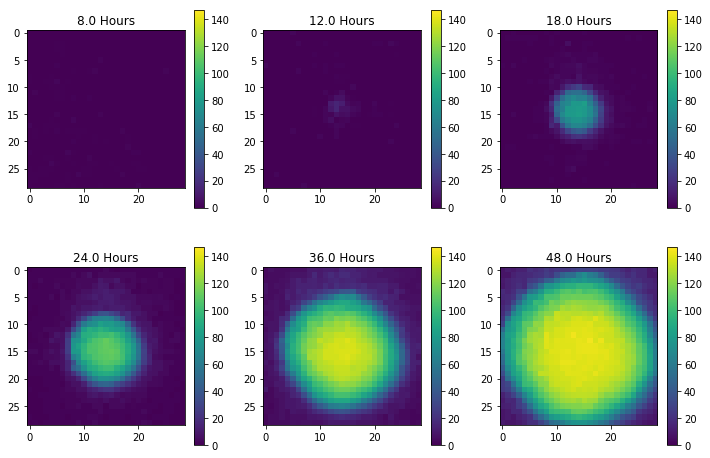

In [225]:
IDCol=int(colonies[2])
fname=(rois_path+'Col'+str(IDCol)+'_ROI_step%d.png')
R_frames=[8,12,18,24,36,48]       # this are positions on the time vector, not directly "times" (e.g. 24 = T[24] and not 24 h)

flup.tl_roi(FRois,T,IDCol,R_frames,fname,chan_sum=True,gridsize=[2,3])
print('Colony '+str(IDCol))

Each line correspond to a different ROI


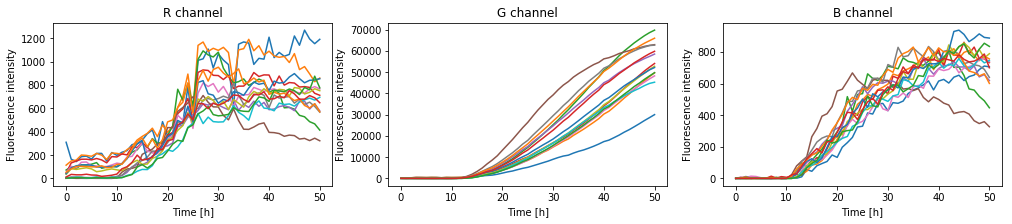

In [226]:
#define the selected colonies
#Cols=[7,15,45,75,79,81,109,123,125]

#use the function to plot
flup.rois_plt_fluo_dynam(FRoisC,T,colonies)
#flup.rois_plt_fluo_dynam(RoisC,T,Cols,filename='Plots/Size_and_fluo/Channel_total_intensity')

print('Each line correspond to a different ROI')

In [227]:
MeanInt=flua.croi_mean_int_frames(DataFsB,nblobD,r_fit,colonies)

Text(0.5,1,'colony 25')

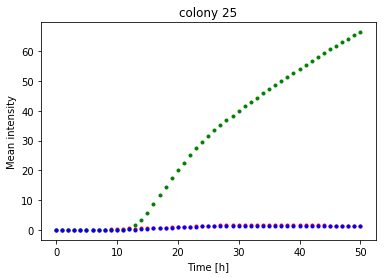

In [228]:
idx=colonies[6]
plt.plot(T,MeanInt['R'][idx],'.',color='r')
plt.plot(T,MeanInt['G'][idx],'.',color='g')
plt.plot(T,MeanInt['B'][idx],'.',color='b')
plt.ylabel('Mean intensity')
plt.xlabel('Time [h]')
plt.title('colony '+str(idx))

In [229]:
#let's sum the three channels
MeanInt3C={}
for i in colonies:
    Vaux=np.zeros((MeanInt['R'][i].shape))
    for c in channels:
        Vaux+=MeanInt[c][i]
    
    MeanInt3C[i]= Vaux

this plot contain the sum of the mean of the three channels over time for each colony


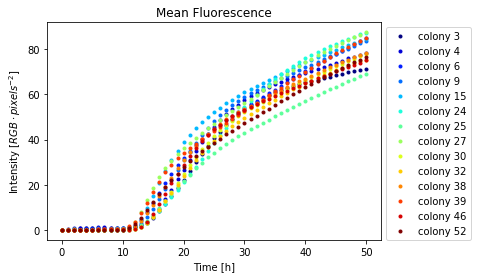

In [230]:
plt.figure()
for i, c in zip(colonies, colors):
    plt.plot(T,MeanInt3C[i],'.',color=c,label='colony '+str(i))

plt.title('Mean Fluorescence')
plt.xlabel('Time [h]')
plt.ylabel('Intensity $[RGB \cdot pixels^{-2}]$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
plt.savefig(F_path+"//MeanInt.pdf", transparent=True) #uncomment to save

print('this plot contain the sum of the mean of the three channels over time for each colony')

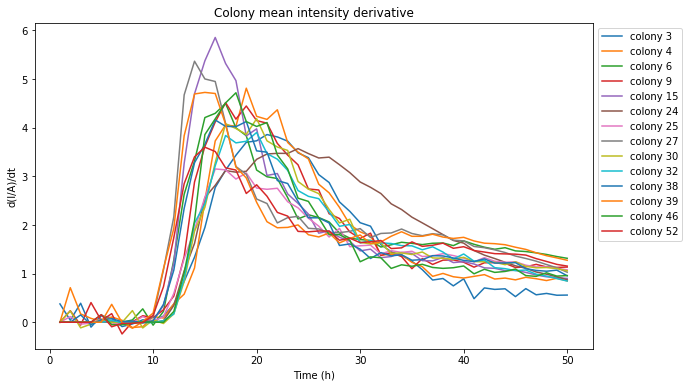

In [231]:
dIAdt_dis={}
plt.figure(figsize=(10,6))
for i in colonies:
    #delta_MeanInt3C is the intensity divided by the area = d(I/A)/dt
    delta_MeanInt3C = np.diff(MeanInt3C[i])
    delta_T=np.diff(T)
    dIAdt_dis[i] = delta_MeanInt3C/delta_T
    plt.plot(T[1:],dIAdt_dis[i],'-',label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel('d(I/A)/dt')
    #plt.ylim([-1,8])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title('Colony mean intensity derivative')

In [232]:
from scipy.interpolate import UnivariateSpline

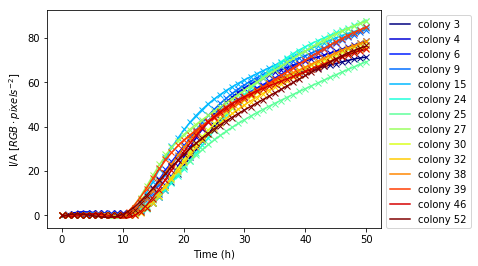

In [233]:
IA_smooth={}

k_spline_IA = 4  # k is the degree of the smoothing spline  (<=5)

for i, c in zip(colonies, colors):
    IA_smooth[i] = UnivariateSpline(T,MeanInt3C[i], k=k_spline_IA )   
    IA_smooth[i].set_smoothing_factor(10)
    plt.plot(T,IA_smooth[i](T[:]),'-',color=c, label='colony '+str(i))
    plt.plot(T,MeanInt3C[i],'x',color=c)
    plt.xlabel('Time (h)')
    plt.ylabel('I/A $[RGB \cdot pixels^{-2}]$')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #plt.legend(loc='upper left')
    #plt.ylim([-5,20])

plt.savefig(F_path+"//IA_smooth.pdf", transparent=True) # Uncomment to save image
#plt.savefig(F_path+"//IA_smooth_labels.pdf", transparent=True) # Uncomment to save image

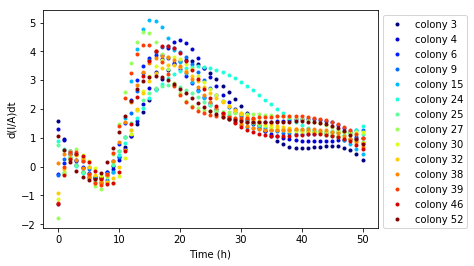

In [234]:
dIAdt={}
for i, c in zip(colonies, colors):
    dIAdt[i]=IA_smooth[i].derivative()   # k is the degree of the smoothing spline  (<=5)
    #dIAdt_smooth[i].set_smoothing_factor(55)
    plt.plot(T,dIAdt[i](T),'.',color=c, label='colony '+str(i))
plt.xlabel('Time (h)')
plt.ylabel('d(I/A)dt')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.ylim([-5,20])
    
#plt.savefig("Plots/Size_and_fluo/d(IA)dt.pdf", transparent=True) #Uncomment to save

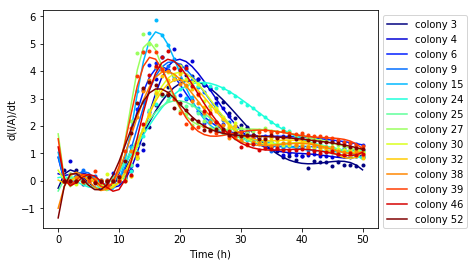

In [249]:
dIAdt_smooth={}

k_spline_dIA = 5    # k is the degree of the smoothing spline  (<=5)
smooth_factor = 2 # >0

for i, c in zip(colonies, colors):
    
    dIAdt_smooth[i] = UnivariateSpline(T[1:],dIAdt_dis[i], k=k_spline_dIA)   
    dIAdt_smooth[i].set_smoothing_factor(smooth_factor)
    
    plt.plot(T[:],dIAdt_smooth[i](T[:]),'-',color=c, label='colony '+str(i))
    plt.plot(T[1:],dIAdt_dis[i],'.',color=c)
    plt.xlabel('Time (h)')
    plt.ylabel('d(I/A)/dt')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #plt.ylim([-5,20])
    
plt.savefig(F_path+"//d(IA)dT_smooth.pdf", transparent=True) #Uncomment to save

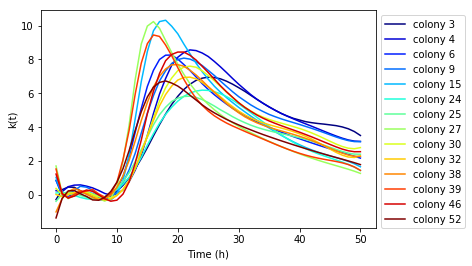

In [250]:
Kf={}
for i, c in zip(colonies, colors):
    Kf[i]=dIAdt_smooth[i](T[:])+Mu_val[i]*MeanInt3C[i]
    plt.plot(T[:],Kf[i],'-',color=c,label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel('k(t)')
    #plt.ylim([-1,10])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    
plt.savefig(F_path+"//K_dynamics.pdf", transparent=True) #Uncomment to save

In [251]:
Kf_max = {}
limits = [10,50]

for i in colonies:
    Kf_values = Kf[i][limits[0]:limits[1]]
    
    max_val = Kf_values.max()
    time_point = np.where( Kf_values == max_val)
    
    Kf_max[i] = [max_val, time_point[0][0]]
    

In [253]:
Kf_max[3][0]

6.952662584911886

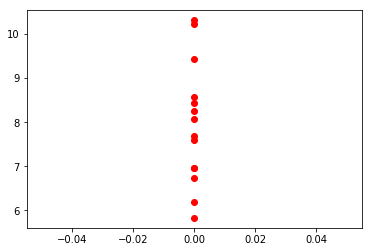

In [254]:
plt.figure()
for i in colonies:
    plt.plot(Kf_max[i][0], 'ro')

In [257]:
#### to save the details at the end
fluo_info = {
    "image_name" : im_fname%(lim),
    "sum_image" : SumData,
    "smooth_sigma": f_smooth_sigma,
    "background_area" : [90, 250, 320, 500],
    "smoothing k IA" : k_spline_IA,
    "smoothing k dIA" : k_spline_dIA,
    "smoothing factor dIA" : smooth_factor
}

### Data Storage

In [258]:
########################################
## Basic information to be fullfilled ##
########################################
folder_name = 'Data'
file_name = 'database'
exp_name = gpath.split("\\")[-1]
g_data_serie = w_data_folder
f_data_serie = f_data_folder

############################################
database = {}

abort = False
state = "store"   # just to display the proper message

# Create data folder if it isn´t
if (folder_name in os.listdir()) == False:
    os.mkdir(folder_name)

## Save the data
if str(file_name)+'.pkl' in os.listdir(folder_name):
    print('BE CAREFUL: There is an existing file whith that name')
    
    while True:
        option = input('do you want to continue? (Y/N): ')
        
        if option == "Y":
            
            database = flua.load_obj(file_name, folder_name)
            state = "actualize"
            print('object '+file_name+".pkl was loaded")
            break
            
        elif option == "N":
            
            abort = True
            print('database storage was aborted ')
            print('please choose a new name')
            break

    
else:
    print("There is no a previous file with that name in the folder. A new one will be created")

if abort == False:
    
    ##################################################################
    # if you want to add another information, add it in this section #
    
    database[exp_name] = {}
    database[exp_name]['Times'] = T
    database[exp_name][g_data_serie] = {}
    database[exp_name][g_data_serie]['Selected colonies'] = colonies
    database[exp_name][g_data_serie]['measured Radius'] = R_frame
    database[exp_name][g_data_serie]['Area fitting'] = A_fitG
    database[exp_name][g_data_serie]['Mu'] = Mu_val
    database[exp_name][g_data_serie]['ROIS'] = Rois
    database[exp_name][g_data_serie]['detection details'] = detection_info
    database[exp_name][g_data_serie]['fitting details'] = fitting_info
    
    database[exp_name][f_data_serie] = {}
    database[exp_name][f_data_serie]['Fluorescence Intensity'] = MeanInt
    database[exp_name][f_data_serie]['Fluo expression rate'] = Kf
    database[exp_name][f_data_serie]['ROIS'] = FRois
    database[exp_name][f_data_serie]['analysis details'] = fluo_info
    
    #################################################################
    
    flua.save_obj(database, file_name, folder_name)
    
    print(file_name +'.pkl was '+state+'d')
   

BE CAREFUL: There is an existing file whith that name
do you want to continue? (Y/N): Y
object database.pkl was loaded
database.pkl was actualized


We can substract this background value from each frame using BG_subst:

In [8]:
DataSB = flua.bg_subst(DataS,BG)

and we can check the effect on the background

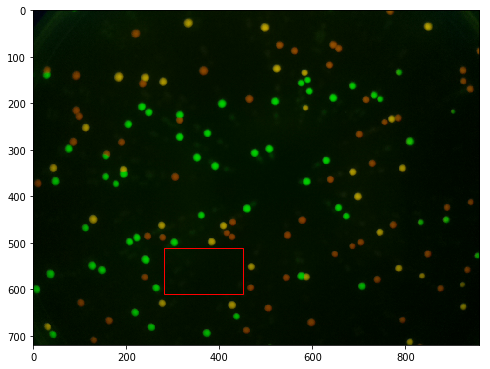

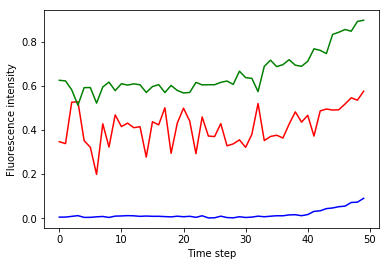

In [9]:
_ = flua.bg_value(512, 610, 280, 450, DataSB, imCount)

Background was practically eliminated.

### Get colony position
Here we are interested on identify the place where colonies are situated

A good way to do it is by sum the value of each pixel for all the channels and all the frames

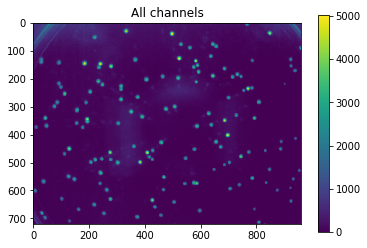

In [10]:
SumData = flua.data_sum_time(DataSB)

Now we can see each colony as a more clear point

#### Filter application
To improve the border detection and reduce the noise is recommended  to apply a filter to smooth the data. A simple and effective gaussian filter is provided by skimage package:
[skimage gaussian filter](http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian)

In [11]:
from skimage.filters import gaussian

The effect of the filter can be understood with the next example:

In [12]:
#see the effect of the filter
a = np.zeros((3, 3))
a[1,1]=1
print('original: \n\n',a)
print('\nfiltered:')
gaussian(a, sigma=1)

original: 

 [[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]

filtered:


array([[0.05855018, 0.09653293, 0.05855018],
       [0.09653293, 0.15915589, 0.09653293],
       [0.05855018, 0.09653293, 0.05855018]])

Then we apply a filter to the data (re-run the next line with different sigma values until you agree the smooth):

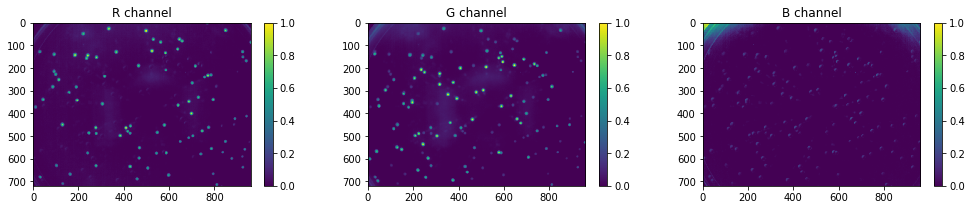

In [13]:
sDatS,sDatSall,sDatST=flua.smooth_data(DataSB,sigma=0.7)

Also, the effect can be seen by plotting a tansect of the image (running next line)

Previous
After Smooth
Sumarized Result


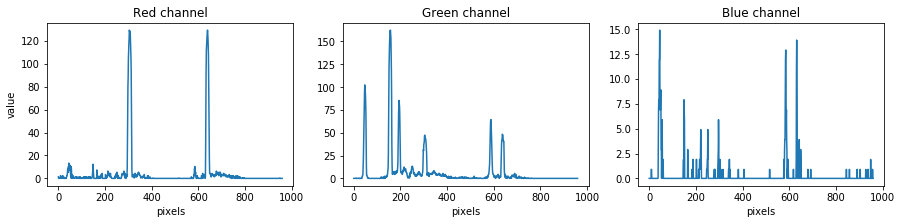

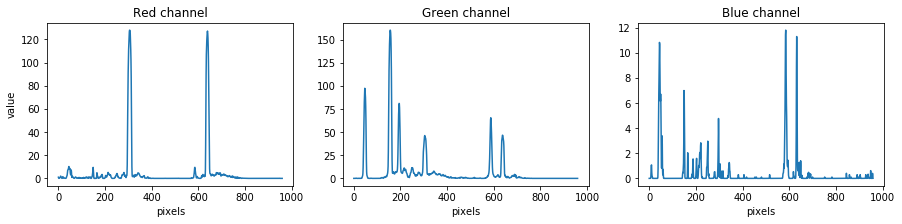

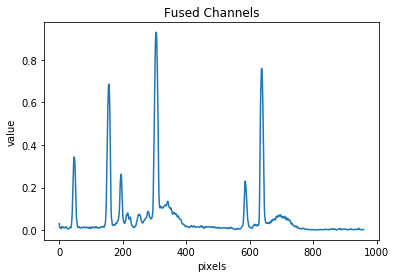

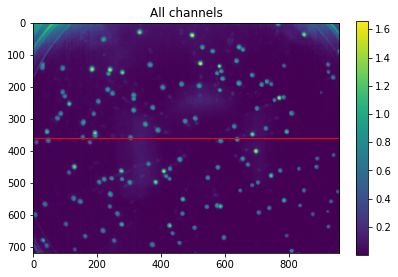

In [14]:
row = int(w/2)    ## int(w/2) is the middle row

print('Previous')
flup.row_transect(DataS,row,show_im=False)

print('After Smooth')
flup.row_transect(sDatST,row,show_im=False)

print('Sumarized Result')
flup.row_transect(sDatSall,row,show_im=True)

#### Blob detection
Scikit-image provides several functions to detect Gaussian-like features ([blobs](http://scikit-image.org/docs/dev/auto_examples/plot_blob.html)). We apply one of these ([blob_log](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log)) to the smoothed sum of intensity, and it returns a list of position (x,y) and width (standard deviation):

To properly identification, it's important to set the **threshold value** for each dataset manually (_i.e._ Define it based on the previous colormap)

Finally, is necessary to identify the maximum and minimun values of "sigma". To afford it, we should stimate the **maximum and minimum values of the colony radious** by doing a zoom over a representative colony.

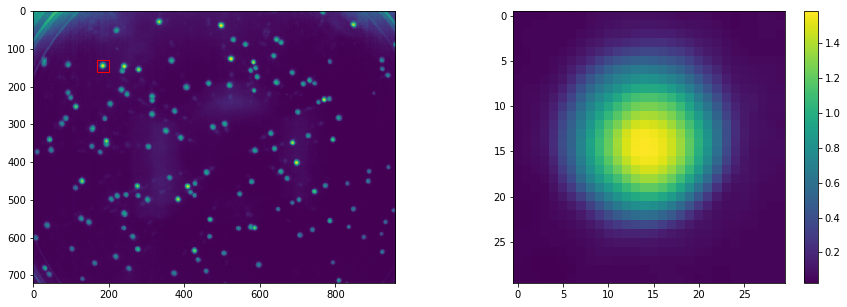

In [15]:
# perform a Zoom by slicing the image:

# modify next values accord the section you want to see:

x_lims = [130,160]    
y_lims = [170,200]    

########################
# Just make the plot ###
########################
flup.im_zoom(x_lims, y_lims, sDatSall)

In [16]:
# assign the stimated radius value

Rmin = 3
Rmax = 11

#perform the sigma limits computation:

Slims = [Rmin/(2**0.5),Rmax/(2**0.5)]
print('sigma limits are: ' + str(Slims))

sigma limits are: [2.1213203435596424, 7.7781745930520225]


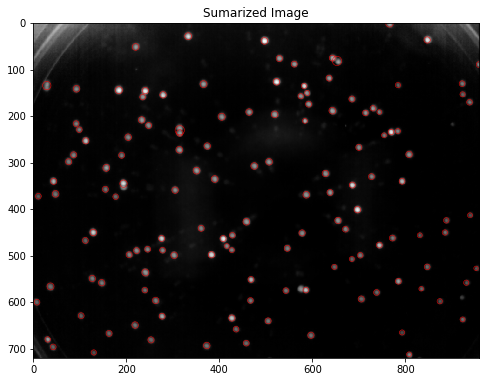

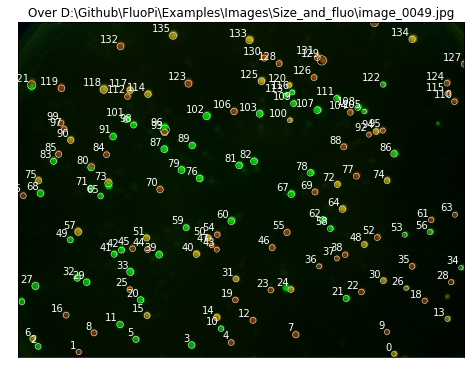

In [17]:
threshold = 0.26
blobD = flua.colony_blobs_id(sDatSall,im_fname%(lim),threshold,sigma_lims = Slims, max_over = 0.8)#,filename='Plots/Size_and_fluo/DetectedBlobs')

Now, min radius should be bigger than the previous selected one, and the max should be lower than the indicated. If not, properly modify the value(s) and run again previous step.

In [18]:
print('min radius is ' + str(blobD[:,2].min()*(2**0.5))+'\n')
print('max radius is ' + str(blobD[:,2].max()*(2**0.5))+'\n')

min radius is 4.696969696969697

max radius is 10.030303030303031



With the previous procedure we have identified where each colony is placed

To perform further analysis on each colony it is necesary to store its regions of interest (ROI) and its data, with size given by the Gaussian width (~ 2 standard deviations).

In [19]:
Rois,RoisC,NC = flua.obtain_rois(sDatST,blobD)

ROI x1 x2 y1 y2
0 705 719 801 816
ROI x1 x2 y1 y2
1 700 717 122 139
ROI x1 x2 y1 y2
2 687 706 34 53
ROI x1 x2 y1 y2
3 683 704 363 384
ROI x1 x2 y1 y2
4 679 698 449 468
ROI x1 x2 y1 y2
5 672 691 244 263
ROI x1 x2 y1 y2
6 672 689 23 40
ROI x1 x2 y1 y2
7 662 681 588 607
ROI x1 x2 y1 y2
8 658 677 154 173
ROI x1 x2 y1 y2
9 657 674 785 802
ROI x1 x2 y1 y2
10 649 668 427 446
ROI x1 x2 y1 y2
11 639 660 209 230
ROI x1 x2 y1 y2
12 631 650 496 515
ROI x1 x2 y1 y2
13 629 646 915 932
ROI x1 x2 y1 y2
14 625 644 418 437
ROI x1 x2 y1 y2
15 621 640 268 287
ROI x1 x2 y1 y2
16 620 639 94 113
ROI x1 x2 y1 y2
17 591 610 0 18
ROI x1 x2 y1 y2
18 590 607 866 883
ROI x1 x2 y1 y2
19 587 606 458 477
ROI x1 x2 y1 y2
20 586 607 253 274
ROI x1 x2 y1 y2
21 584 603 696 715
ROI x1 x2 y1 y2
22 570 589 729 748
ROI x1 x2 y1 y2
23 566 585 534 553
ROI x1 x2 y1 y2
24 565 584 577 596
ROI x1 x2 y1 y2
25 566 583 232 249
ROI x1 x2 y1 y2
26 564 579 827 842
ROI x1 x2 y1 y2
27 555 578 26 49
ROI x1 x2 y1 y2
28 550 567 923 940
ROI x

ROI x1 x2 y1 y2
106 181 202 454 475
ROI x1 x2 y1 y2
107 178 199 633 654
ROI x1 x2 y1 y2
108 175 192 722 739
ROI x1 x2 y1 y2
109 165 184 583 602
ROI x1 x2 y1 y2
110 161 180 929 948
ROI x1 x2 y1 y2
111 154 173 676 695
ROI x1 x2 y1 y2
112 151 168 227 244
ROI x1 x2 y1 y2
113 149 166 567 584
ROI x1 x2 y1 y2
114 144 165 269 290
ROI x1 x2 y1 y2
115 145 162 915 932
ROI x1 x2 y1 y2
116 142 159 581 598
ROI x1 x2 y1 y2
117 135 156 231 252
ROI x1 x2 y1 y2
118 133 156 173 196
ROI x1 x2 y1 y2
119 131 152 83 104
ROI x1 x2 y1 y2
120 127 144 574 591
ROI x1 x2 y1 y2
121 121 148 16 43
ROI x1 x2 y1 y2
122 125 142 776 793
ROI x1 x2 y1 y2
123 120 143 355 378
ROI x1 x2 y1 y2
124 121 140 913 932
ROI x1 x2 y1 y2
125 116 137 513 534
ROI x1 x2 y1 y2
126 109 128 627 646
ROI x1 x2 y1 y2
127 80 99 950 959
ROI x1 x2 y1 y2
128 79 98 552 571
ROI x1 x2 y1 y2
129 67 96 639 668
ROI x1 x2 y1 y2
130 67 86 520 539
ROI x1 x2 y1 y2
131 66 85 634 653
ROI x1 x2 y1 y2
132 41 62 210 231
ROI x1 x2 y1 y2
133 28 49 487 508
ROI x1 x2

we can ilustrate the data with the first blob (colony)

In [20]:
# show the first column of the first ROI
print('Whole ROI')
print(Rois['R'][0][:,1,1])

print('\n"Circular" ROI')
print(RoisC['R'][0][:,1,1]) #it contains only the pixels inside the circular region, and make the other equal to zero

Whole ROI
[0.00333908 0.0171975  0.05077247 0.04343582 0.0616042  0.12283618
 0.28540822 0.11561304 0.18335065 0.71545135 0.9395649  0.3257922
 0.03810843 0.22435488]

"Circular" ROI
[0.         0.         0.         0.         0.         0.
 0.28540822 0.11561304 0.18335065 0.         0.         0.
 0.         0.        ]


The ROI let us to track every colony in a seperatelly way. The module includes a package to save an image of a selected ROI (`idx`) at selected times (`Times`). Then is possible make timelapse grow of an indivial colony.

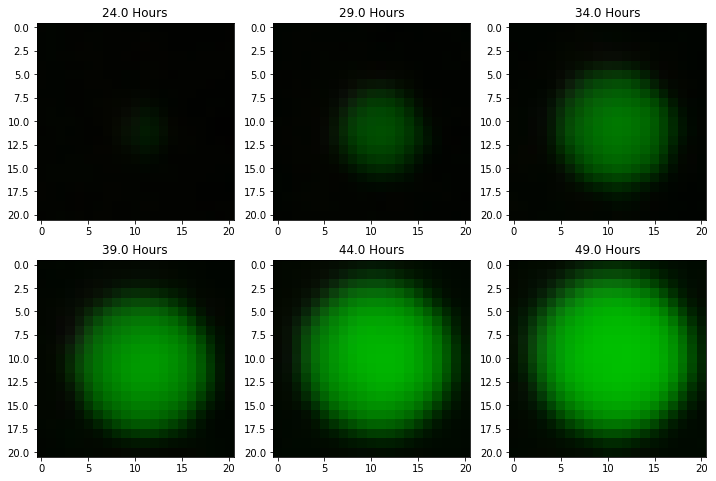

In [21]:
#Green example
idx=79
fname=('ROIs/Col'+str(idx)+'_ROI_step%d.png')
Frames=[24,29,34,39,44,49]       # this are positions on the time vector, not directly "times" (e.g. 24 = T[24] and not 24 h)

flup.tl_roi(Rois,T,idx,Frames,fname,gridsize=[2,3])

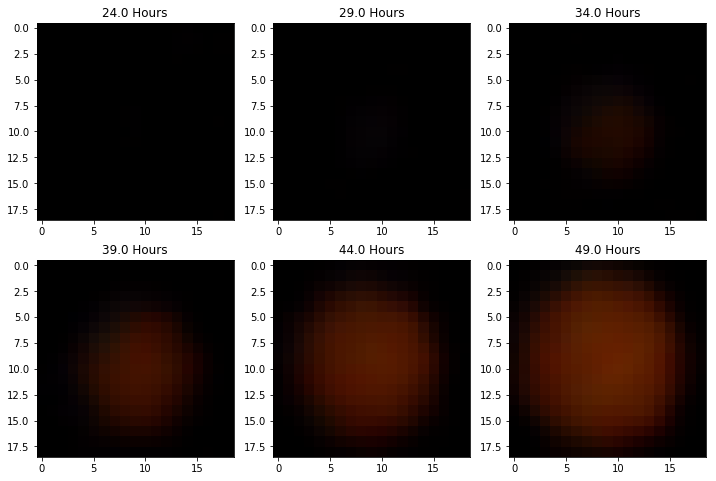

In [22]:
#Red example
idx=66
fname=('ROIs/Col'+str(idx)+'_ROI_step%d.png')
Frames=[24,29,34,39,44,49]

flup.tl_roi(Rois,T,idx,Frames,fname,gridsize=[2,3])

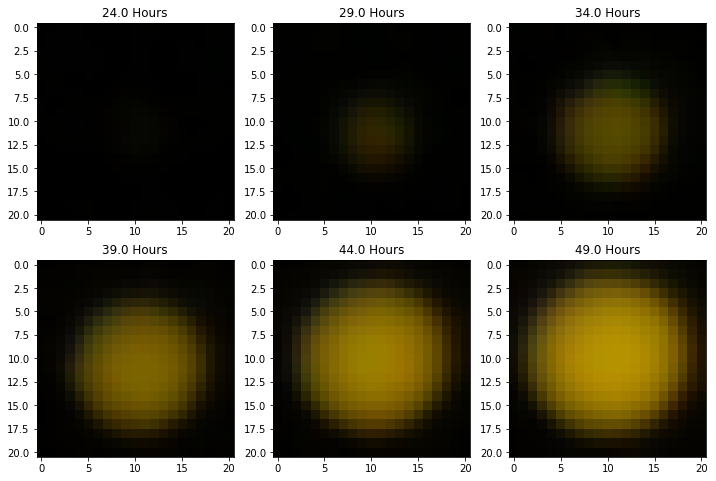

In [23]:
#Orange example
idx=125
fname=('ROIs/Col'+str(idx)+'_ROI_step%d.png')
Frames=[24,29,34,39,44,49]

flup.tl_roi(Rois,T,idx,Frames,fname,gridsize=[2,3])

### Time dynamics of colonies
As we have estimated colony location (and maximmum size), we can analyse the dynamics of fluorescence and growth of them. 

#### Fluorescence dynamics
With the data obtained so far we can plot the fluorescence dynamics of colonies. We can choose some representative colonies and use the FluoPi `rois_plt_fluo_dynam()` function to perform this task:

Each line correspond to a different ROI


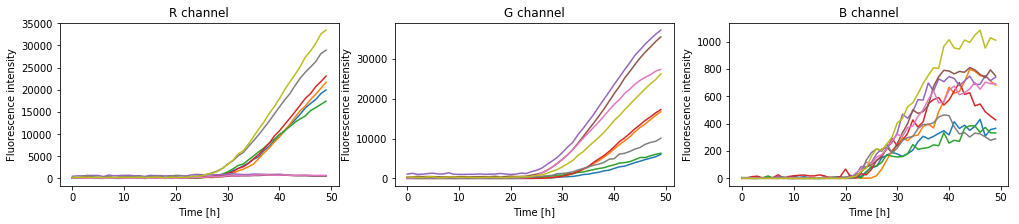

In [21]:
#define the selected colonies
Cols=[7,15,45,75,79,81,109,123,125]

#use the function to plot
flup.rois_plt_fluo_dynam(RoisC,T,Cols)
#flup.rois_plt_fluo_dynam(RoisC,T,Cols,filename='Plots/Size_and_fluo/Channel_total_intensity')

print('Each line correspond to a different ROI')

#### Colony radius growth
We have the location and a final size estimate based on the total fluorescence of each colony over the time-lapse. We would like to know the size of the colony in each frame; from this we can compute the growth rate.

One way to do this is to find Gaussian blobs in each of the image regions of the colony, for each frame of the time-lapse. It works, but is a bit slow.

First we perform the sum of all channels for each frame to get the best representation of colony size:

In [22]:
ACRois=flua.channels_sum(RoisC,Cols) #circular ROIS

In [23]:
ACRoisS=flua.channels_sum(Rois,Cols) #square ROIS

The following loop finds blobs and stores the width in each frame. The result is a *dict* containing the sigma value of the size at each time point for every selected colony

In [24]:
# This block could be a bit slow, don't get stressed.

tl_threshold = 0.37

import time
start = time.time()
R_frame = flua.frame_colony_radius(ACRoisS, Cols, tl_threshold, max_sig = Slims[1])
end = time.time()
print(str(end - start)+' seg') #to know how long it takes to run

250.7979519367218 seg


Since the colony is roughly circular and flat, an estimate of volume is $R^2$. Lets plot this for some colonies. Plotting the log is useful because the slope is the relative growth rate. We can see the colonies slow their growth during the experiment.

Each line correspond to one colony


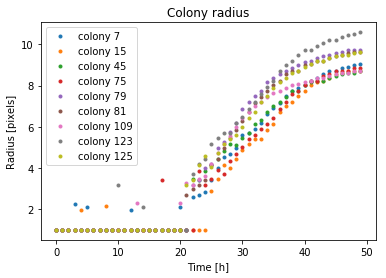

In [25]:
#flup.plot_radius(R_frame, Cols, T)
flup.plot_radius(R_frame, Cols, T)
print('Each line correspond to one colony')

#### Check the radius estimate
To see how well the colony size is estimated, we can compare to the profile of a colony in a slice of its image region. The radius (red line) should give the border of the colony.

D:\Github\FluoPi\Examples\fluopi\plotting.py:521: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_dots != 'null':


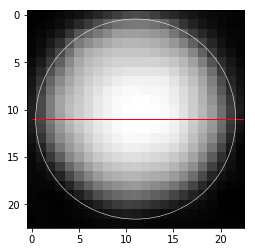

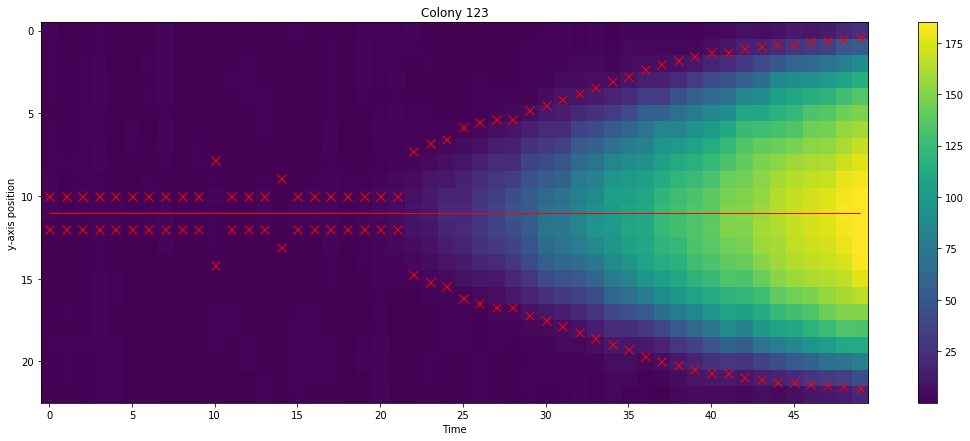

In [26]:
IDCol=Cols[7]

# See one frame of the colony
flup.ROI_radius(ACRoisS, IDCol, frame= -1, r= R_frame, transect = True , plt_circle = True)

# See the time serie transect radius
flup.check_radius(ACRoisS, IDCol, T, r_dots=R_frame[IDCol], transect=True)
#flup.check_radius(ACRoisS, IDCol, T, r_dots=R_frame[IDCol], transect=True,filename='Plots/Size_and_fluo/Kymograph_'+str(IDCol))


##### Getting the colony area over time $A(t)$
with the radius value we are able to get the colony area over time by taking it as a perfect circle: $$A(t) = \pi \cdot r^{2}$$

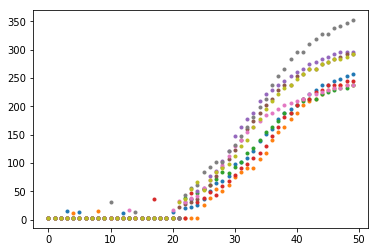

In [27]:
A = flua.area(R_frame,Cols,T)

To improve determination of radius we can fix a monotonically incresing function to the obstained values for each colony. This function could be of sigmodial type:
\begin{equation}
A(t) = \frac{a}{1+ e^{-d(t+b)}}
\end{equation}

where $a$ is the maximum area of the colony ($a = A_{max}$) and  $b$ is the time where the colony reach half of his maximum growth ($b = t_d$)

You can se the effect of the parameters evaluating the function F_logistic:

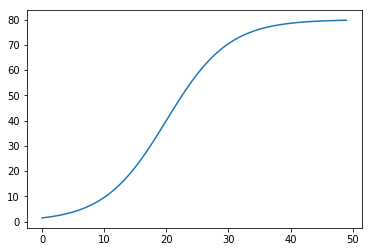

In [28]:
Sigmoid = flua.f_sigma(T, 80, -20, 0.2)
plt.plot(T,Sigmoid)

With the function `function_fit` you can fit a mathematical model (*F_sigma* by default) to one seleceted colony:

[ 2.44639463e+02 -3.22852490e+01  1.92823798e-01]


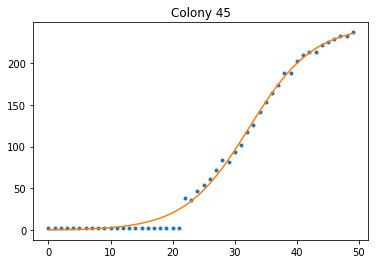

In [29]:
idx=Cols[2:3] # idx have to be an array, then to select one colony use this notation Cols[desired:desired+1]
init=20
end=-1
SingleF=flua.function_fit(T,A,init,end,idx)

or you can perform the fit to a dictionary of selected colonies with the same function:

In [56]:
?flua.function_fit

[ 2.60664332e+02 -3.34362427e+01  2.07340154e-01]


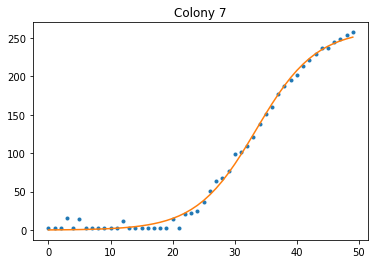

[ 2.52877280e+02 -3.49827342e+01  2.16353226e-01]


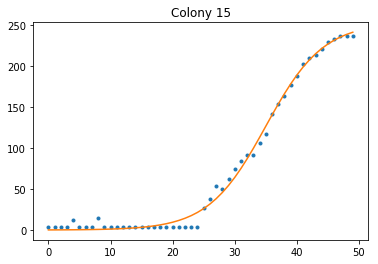

[ 2.41028900e+02 -3.21320930e+01  2.03287842e-01]


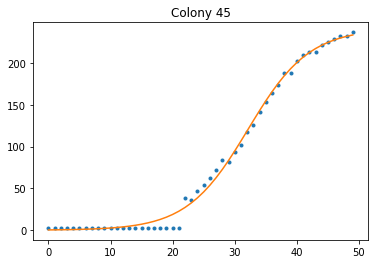

[ 2.62471335e+02 -3.44627088e+01  1.99911108e-01]


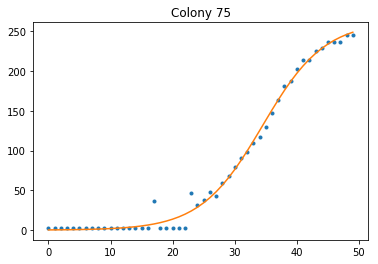

[ 2.89826573e+02 -3.04160278e+01  2.57418350e-01]


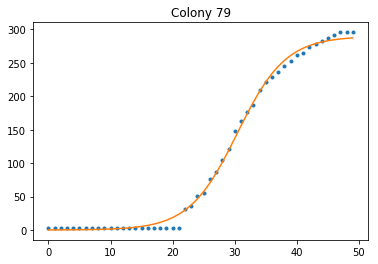

[ 2.86882073e+02 -3.13266558e+01  2.41800600e-01]


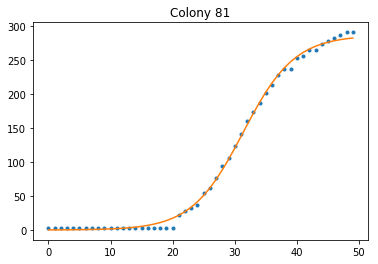

[230.54870046 -29.42919766   0.24933465]


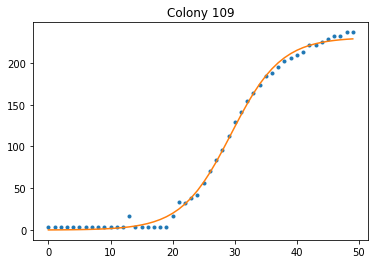

[ 3.60051119e+02 -3.27059764e+01  1.98444173e-01]


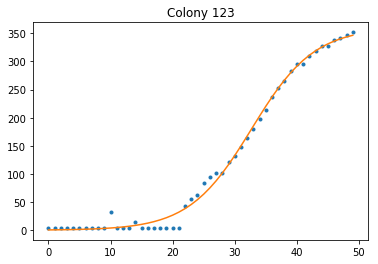

[ 2.95529611e+02 -3.19838621e+01  2.10616975e-01]


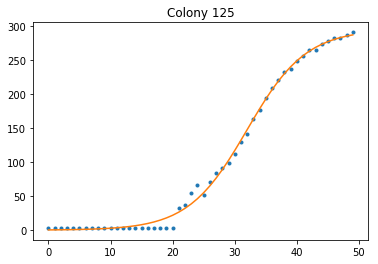

In [30]:
init=10
end=-1
A_fitS=flua.function_fit(T,A,init,end,Cols)

We can put alltogheter on one plot:

In [31]:
#set the color vector to have concordance between dots and fitted curves
colors = plt.cm.jet(np.linspace(0, 1, len(Cols))) #Paired o jet #https://matplotlib.org/users/colormaps.html


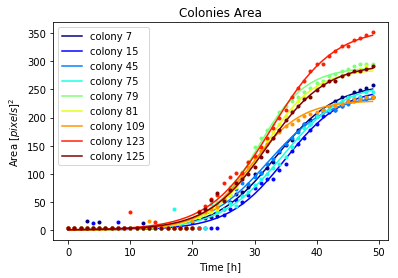

In [32]:
for i, c in zip(Cols, colors):
    plt.plot(T,A[i],'.',color=c)
    plt.plot(T,A_fitS[i][0],'-',color=c,label='colony '+str(i))

plt.xlabel('Time [h]')
plt.ylabel('Area $[pixels]^2$') 
plt.title('Colonies Area')
#plt.xlabel('Time [h]')
plt.legend(loc='upper left')
#plt.savefig("Plots/Size_and_fluo/AreaFit.pdf", transparent=True)  # Uncomment this line to save

With the area function we are able to back-compute the radius: $$ r (t) = \sqrt{\frac{A(t)}{\pi}} $$

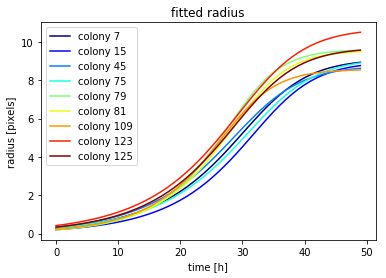

In [33]:
from math import pi
r_fit={}

plt.figure()
for i, c in zip(Cols, colors):
    r_fit[i]=(A_fitS[i][0]/pi)**(0.5)
    
    plt.plot(T,r_fit[i],'-',color=c,label='colony '+str(i))

plt.title('fitted radius')
plt.ylabel('radius [pixels]')
plt.xlabel('time [h]')
plt.legend(loc='upper left')
#plt.savefig("Plots/Size_and_fluo/colonyRadiusFit.pdf", transparent=True)

We can plot it and the blob radius together:

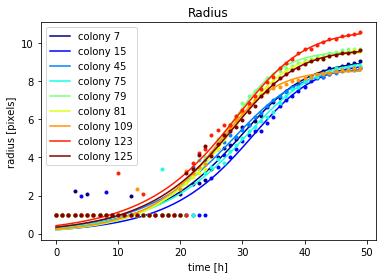

In [34]:
#fluopi.plot_radius(R_frame5,Cols,T)
for i, c in zip(Cols, colors):
    plt.plot(T,R_frame[i],'.',color=c)
    plt.plot(T,r_fit[i],'-',color=c,label='colony '+str(i))
plt.title('Radius')
plt.ylabel('radius [pixels]')
plt.xlabel('time [h]')
plt.legend(loc='upper left')
#plt.savefig("Plots/Size_and_fluo/colonyRadiusFit_points.pdf", transparent=True)

Now we can check the radius fitting:

D:\Github\FluoPi\Examples\fluopi\plotting.py:516: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_fit != 'null':
D:\Github\FluoPi\Examples\fluopi\plotting.py:521: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_dots != 'null':


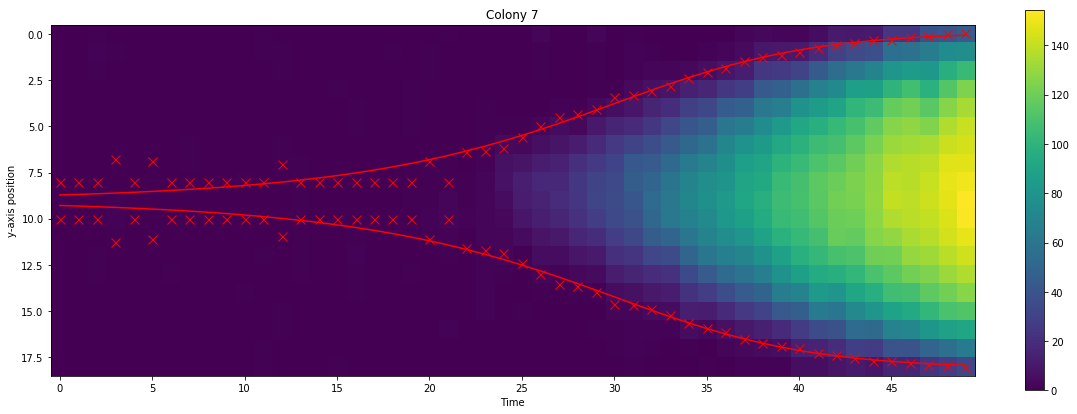

In [35]:
IDCol=int(Cols[0])

flup.check_radius(ACRoisS,IDCol,T,r_fit=r_fit[IDCol],r_dots=R_frame[IDCol])
#flup.check_radius(ACRoisS,IDCol,T,r_fit=r_fit[IDCol],r_dots=R_frame[IDCol], filename='Plots/Size_and_fluo/3Kymograph_fit2_color_'+str(IDCol))

D:\Github\FluoPi\Examples\fluopi\plotting.py:305: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if radius != 'null':
D:\Github\FluoPi\Examples\fluopi\plotting.py:343: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if radius != 'null':


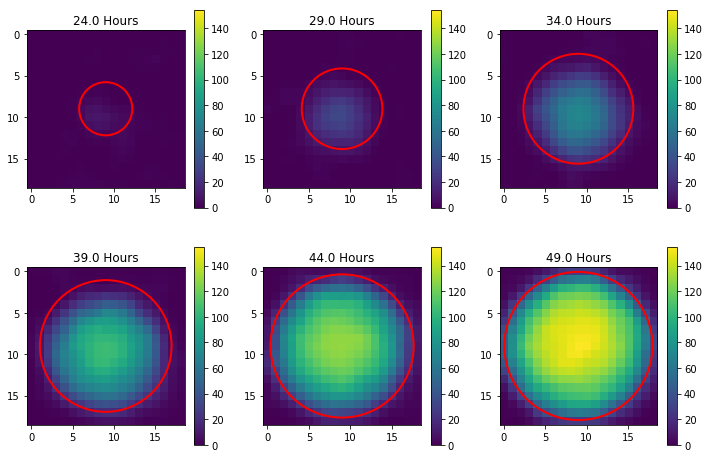

In [36]:
IDCol=Cols[0]
fname=('ROIs/sumCol'+str(IDCol)+'_ROI_step%d.pdf')
Frames=[24,29,34,39,44,49]

flup.tl_roi(Rois,T,IDCol,Frames,fname,radius=r_fit[IDCol], chan_sum=True, same_bar= True, gridsize=[2,3]) 

colony grows stimation seems to get more cotinuous and improve greatly at the beginning.

### Parameter estimation from data

We now have information about sub-populations of bacteria (colonies) on the same plate. The fluorescence in each region of interest estimates the time varying fluorescent protein level in each colony. The radius (or $R^2$) approximates the size of each sub-population (colony) and so is similar to optical density (OD) in a bulk plate-reader experiment. 

Lets write a simple model of fluorescent protein expression from a single cell:

\begin{equation}
\frac{dF}{dt} = k(t) - (\mu(t) + \delta(t))F
\end{equation}

where $F$ is the cell's fluorescent protein concentration, which is produced at time-varying rate $k(t)$. The cell grows at relative rate $\mu(t)=(1/V)dV/dt$ ($V=$volume) causing dilution, but assuming a constant thickness of the colony it becomes proportional to the area: $\mu(t)=(1/A)dA/dt$ ($A=$area). 
The protein is degraded at rate $\delta(t)$.


For the proteins we are using we will assume that $\delta(t)=0$ for all times. We measure the total fluorescence intensity, which is the concentration $F$ multiplied by the total volume of the colony $A_{tot} = \pi R^2$. Hence,

\begin{equation}
I(t) = F(t)A(t) \approx F(t) \pi R^2(t)
\end{equation}

From these equations it is possible to derive (see [maths](https://github.com/SynBioUC/FluoPi/blob/5533704f41cf62f56551a40159e8ebd785a2b66b/Maths/Fluorescence%2Bmaths.pdf)) the fluorescent expresion rate constant could be represented by: $$ K_f = \frac{d(I/A)}{dt} + \mu \cdot (I/A) $$


To be able to estimate the value of this parameter we have to compute the values of each element in his representative equation.

To get an acurate analysis of the gener expression dynamics of the colonies, the module include a function to compute the average fluorescent value inside the limits of the colony (defined by the radius fitting) on each time. This average value correspond to $I/A$ (see the [maths](https://github.com/SynBioUC/FluoPi/blob/5533704f41cf62f56551a40159e8ebd785a2b66b/Maths/Fluorescence%2Bmaths.pdf))

In [37]:
MeanInt=flua.croi_mean_int_frames(sDatST,blobD,r_fit,Cols)

Text(0.5,1,'colony 7')

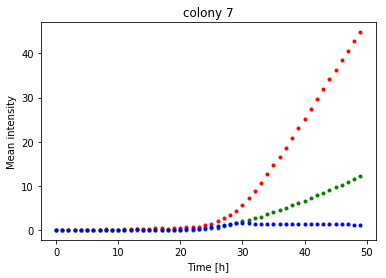

In [38]:
idx=Cols[0]
plt.plot(T,MeanInt['R'][idx],'.',color='r')
plt.plot(T,MeanInt['G'][idx],'.',color='g')
plt.plot(T,MeanInt['B'][idx],'.',color='b')
plt.ylabel('Mean intensity')
plt.xlabel('Time [h]')
plt.title('colony '+str(idx))

by sum the three channels we can get the total intensity per area $(I/A)_{total}$

In [39]:
#let's sum the three channels
MeanInt3C={}
for i in Cols:
    Vaux=np.zeros((MeanInt['R'][i].shape))
    for c in channels:
        Vaux+=MeanInt[c][i]
    
    MeanInt3C[i]= Vaux

this plot contain the sum of the mean of the three channels over time for each colony


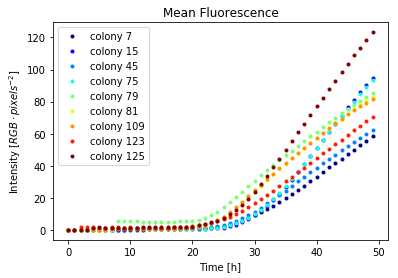

In [40]:
plt.figure()
for i, c in zip(Cols, colors):
    plt.plot(T,MeanInt3C[i],'.',color=c,label='colony '+str(i))

plt.title('Mean Fluorescence')
plt.xlabel('Time [h]')
plt.ylabel('Intensity $[RGB \cdot pixels^{-2}]$')
plt.legend(loc='upper left')
    
#plt.savefig("Plots/Size_and_fluo/MeanInt.pdf", transparent=True) #uncomment to save

print('this plot contain the sum of the mean of the three channels over time for each colony')

With that is possible to compute the derivative of this value: $ d(I/A)/dt $

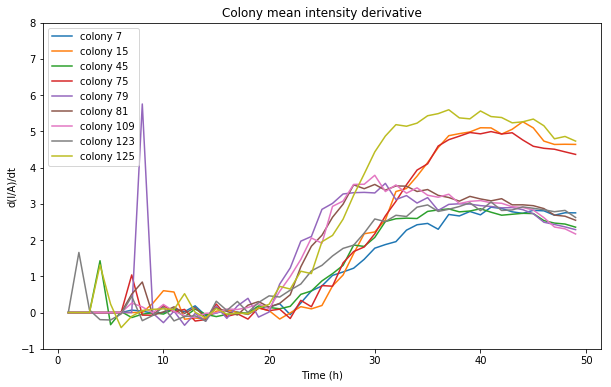

In [41]:
dIAdt_dis={}
plt.figure(figsize=(10,6))
for i in Cols:
    #delta_MeanInt3C is the intensity divided by the area = d(I/A)/dt
    delta_MeanInt3C = np.diff(MeanInt3C[i])
    delta_T=np.diff(T)
    dIAdt_dis[i] = delta_MeanInt3C/delta_T
    plt.plot(T[1:],dIAdt_dis[i],'-',label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel('d(I/A)/dt')
    plt.ylim([-1,8])
    plt.legend(loc='upper left')
    plt.title('Colony mean intensity derivative')

Finally, we should compute the $\mu(t)=(1/A)dA/dt$
, which under the sigmoideal growth moldel it's equal to: $$\mu = \frac{d}{e^{d \cdot (t+b)}+1} $$

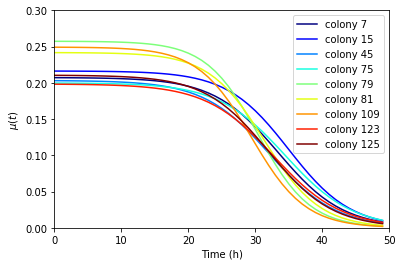

In [42]:
Mu_val={}
for i, c in zip(Cols, colors):
    Mu_val[i]=flua.f_mu(T,A_fitS[i][1][1],A_fitS[i][1][2])
    plt.plot(T,Mu_val[i],'-',color=c,label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel(r'$\mu (t)$')
    plt.xlim([0,50])
    plt.ylim([0,0.30])
    plt.legend(loc='upper right')
#plt.savefig("Plots/Size_and_fluo/GrowthRate.pdf", transparent=True) # Uncomment to save


## Data smoothing

To perform an accurated estimation it's good to apply data smoothing.

In [43]:
from scipy.interpolate import UnivariateSpline

[Univariate Spline Documentation](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.interpolate.UnivariateSpline.html)

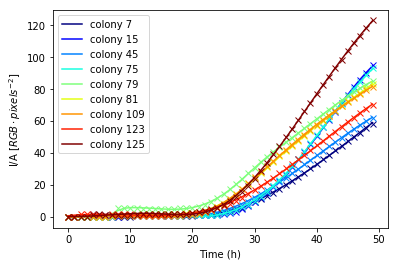

In [44]:
IA_smooth={}

for i, c in zip(Cols, colors):
    IA_smooth[i] = UnivariateSpline(T,MeanInt3C[i], k=3)   # k is the degree of the smoothing spline  (<=5)
    IA_smooth[i].set_smoothing_factor(10)
    plt.plot(T,IA_smooth[i](T[:]),'-',color=c, label='colony '+str(i))
    plt.plot(T,MeanInt3C[i],'x',color=c)
    plt.xlabel('Time (h)')
    plt.ylabel('I/A $[RGB \cdot pixels^{-2}]$')
    plt.legend(loc='upper left')
    #plt.ylim([-5,20])
    
#plt.savefig("Plots/Size_and_fluo/IA_smooth.pdf", transparent=True) # Uncomment to save image

From this smooth values of _IA_ we can compute his derivative:

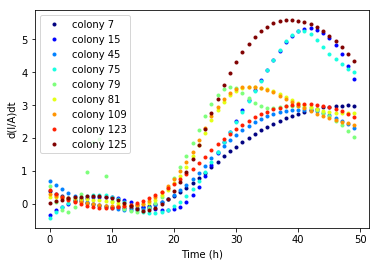

In [45]:
dIAdt={}
for i, c in zip(Cols, colors):
    dIAdt[i]=IA_smooth[i].derivative()   # k is the degree of the smoothing spline  (<=5)
    #dIAdt_smooth[i].set_smoothing_factor(55)
    plt.plot(T,dIAdt[i](T),'.',color=c, label='colony '+str(i))
plt.xlabel('Time (h)')
plt.ylabel('d(I/A)dt')
plt.legend(loc='upper left')
#plt.ylim([-5,20])
    
#plt.savefig("Plots/Size_and_fluo/d(IA)dt.pdf", transparent=True) #Uncomment to save

Or we can make the smooth of the previuos *dIAdt_dis* computed values:

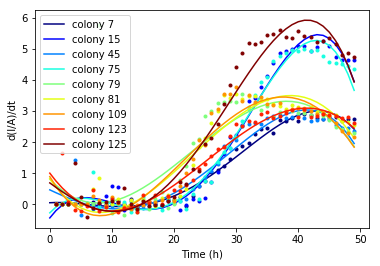

In [46]:
dIAdt_smooth={}

for i, c in zip(Cols, colors):
    dIAdt_smooth[i] = UnivariateSpline(T[1:],dIAdt_dis[i], k=4)   # k is the degree of the smoothing spline  (<=5)
    #dIAdt_smooth[i].set_smoothing_factor(55)
    plt.plot(T[:],dIAdt_smooth[i](T[:]),'-',color=c, label='colony '+str(i))
    plt.plot(T[1:],dIAdt_dis[i],'.',color=c)
    plt.xlabel('Time (h)')
    plt.ylabel('d(I/A)/dt')
    plt.legend(loc='upper left')
    #plt.ylim([-5,20])
    
#plt.savefig("Plots/Size_and_fluo/d(IA)dT_smooth.pdf", transparent=True) #Uncomment to save
    

Finally, the fluorescent expresion rate constant could be represented by: $$ K_f = \frac{d(I/A)}{dt} + \mu \cdot (I/A) $$

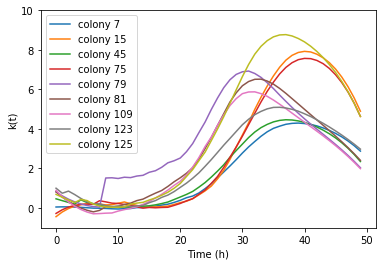

In [47]:
Kf={}
for i, c in zip(Cols, colors):
    Kf[i]=dIAdt_smooth[i](T[:])+Mu_val[i]*MeanInt3C[i]
    plt.plot(T[:],Kf[i],'-',label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel('k(t)')
    plt.ylim([-1,10])
    plt.legend(loc='upper left')
    
#plt.savefig("Plots/Size_and_fluo/K_dynamics.pdf", transparent=True) #Uncomment to save

## Data storage

Finally, we should save the obtained data of these analysis.

In [65]:
########################################
## Basic information to be fullfilled ##
########################################
folder_name = 'Data'
file_name = 'database'
exp_name = fpath.split("\\")[-1]

############################################
database = {}

abort = False
state = "store"   # just to display the proper message

if str(file_name)+'.pkl' in os.listdir(folder_name):
    print('BE CAREFUL: There is an existing file whith that name')
    
    while True:
        option = input('do you want to continue? (Y/N): ')
        
        if option == "Y":
            
            database = flua.load_obj(file_name, folder_name)
            state = "actualize"
            print('object '+file_name+".pkl was loaded")
            break
            
        elif option == "N":
            
            abort = True
            print('database storage was aborted ')
            print('please choose a new name')
            break

    
else:
    print("There is no a previous file with that name in the folder. A new one will be created")

if abort == False:
    
    ##################################################################
    # if you want to add another information, add it in this section #
    
    database[exp_name] = {}
    database[exp_name]['Times'] = T
    database[exp_name]['Selected colonies'] = Cols
    database[exp_name]['Radius'] = R_frame
    database[exp_name]['Fluorescence Intensity'] = MeanInt
    database[exp_name]['Mu'] = Mu_val 
    database[exp_name]['Fluo expression rate'] = Kf
    database[exp_name]['ROIS'] = Rois
    
    #################################################################
    
    flua.save_obj(database, file_name, folder_name)
    
    print(file_name +'.pkl was '+state+'d')
   

There is no a previous file with that name in the folder. A new one will be created
database.pkl was stored
